# cloud cover code

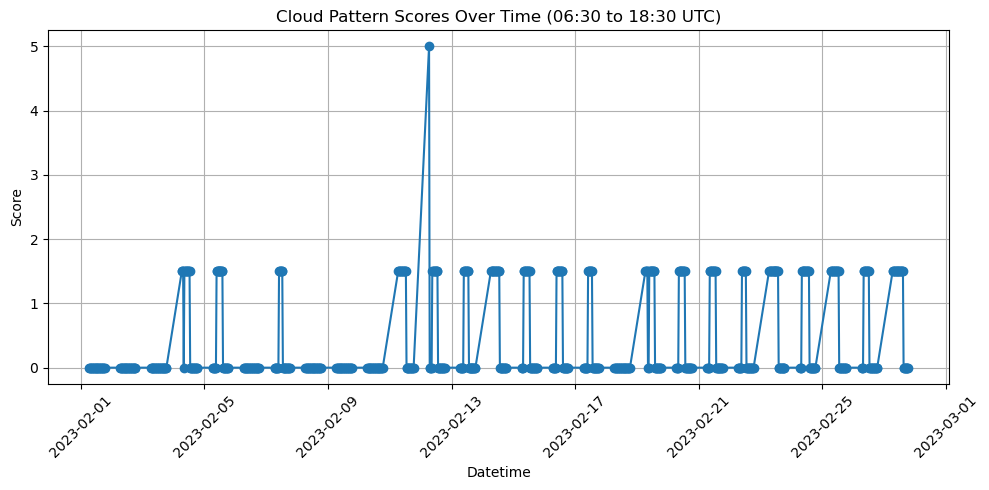

In [1]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, time

# Regular expression pattern to match cloud information
cloud_pattern = r'\b(?:SKC|NCD|CLR|NSC|FEW|CAVOK|SCT)(?:\d{3})?\b'

# Initialize lists to store datetime and scores
datetimes = []
scores = []

# Open the METAR file
with open('C:/Users/Lab/Downloads/METAR_feb_2023.txt', 'r') as file:
    # Read each line of the file
    for line in file:
        # Extract cloud information from the line
        cloud_info = re.findall(cloud_pattern, line)
        
        # Extract date and time from the line
        datetime_match = re.search(r'\b(\d{4}-\d{2}-\d{2} \d{2}:\d{2})\b', line)
        if datetime_match:
            datetime_str = datetime_match.group(0)
            current_datetime = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')
            
            # Check if time is within the specified range (06:30 to 18:30 UTC)
            if time(6, 30) <= current_datetime.time() <= time(18, 30):
                datetimes.append(current_datetime)
                
                # Assign scores based on cloud patterns
                score = 5  # Default score
                for pattern in cloud_info:
                    cloud_pattern_short = pattern[:3]  # Extract initial three characters
                    if cloud_pattern_short in ['SKC', 'NCD', 'CLR', 'NSC','FEW','SCT']:
                        score = 0
                    elif pattern == 'CAVOK':
                        score = 1.5
                scores.append(score)

# Plot score versus datetime
plt.figure(figsize=(10, 5))
plt.plot(datetimes, scores, marker='o', linestyle='-')
plt.xlabel('Datetime')
plt.ylabel('Score')
plt.title('Cloud Pattern Scores Over Time (06:30 to 18:30 UTC)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
def select_and_drop_data(data_array, start_time="06:30", end_time="18:30"):
    """
    Select data within the time range of 6:30 to 18:30 UTC for each day and drop other values.

    Parameters:
        data_array (xarray.DataArray): Input DataArray with time dimension.
        start_time (str): Start time of the range in "HH:MM" format (default: "06:30").
        end_time (str): End time of the range in "HH:MM" format (default: "18:30").

    Returns:
        xarray.DataArray: DataArray with data selected within the specified time range for each day.
    """
    # Convert time coordinate to a pandas Series
    time_series = pd.Series(data_array.time.values)
    
    # Get unique days (only date part)
    unique_days = time_series.dt.floor("D").dt.date.unique()
    
    # Initialize list to store selected data for each day
    selected_data = []
    
    # Iterate over each unique day
    for day in unique_days:
        # Select data within the time range for the current day
        start_datetime = pd.Timestamp(f"{day} {start_time}:00")
        end_datetime = pd.Timestamp(f"{day} {end_time}:00")
        selected_data_day = data_array.sel(time=slice(start_datetime, end_datetime))
        
        # Drop values outside the specified time range
        selected_data_day = selected_data_day.where((selected_data_day.time >= start_datetime) & (selected_data_day.time <= end_datetime), drop=True)
        
        selected_data.append(selected_data_day)
    
    # Concatenate selected data for all days
    selected_data_concatenated = xr.concat(selected_data, dim="time")
    
    return selected_data_concatenated


# windcube code

In [2]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import DateFormatter
import concurrent.futures
import time as tm
from scipy.signal import savgol_filter
from scipy.optimize import fsolve
%config Completer.use_jedi = False

In [3]:
def wc_data_dbs(var_code, varb_h1, varb_h2,  varb_h3, varb_h4,  varb_h5,
                varb_h6, varb_h7, varb_h8, varh_b9, ini_time, fin_time):
    """ 
    It reads ('dbs') file in given time,
    initial and final time as input. It returns that variable
    in that time frame.
    """
    
    wc_path = "D:/windcube_data/"
    tt_0 = ini_time
    i = 0
    while (tt_0<=fin_time):
        t_path = wc_path+'Y'+str(tt_0)[0:4]+'/M'+str(tt_0)[5:7]+'/'                                                                   
        for folder in sorted(os.listdir(t_path)):                        # entering into each daily floder
            if folder[1:3] == str(tt_0)[8:10]:
                file_all = sorted(os.listdir(t_path+'/'+folder)) #listing all file in a particular day folder
                for file in file_all:
                    if file[-13:-10] == var_code:
                        file_x = xr.open_dataset(t_path+'/'+folder+'/'+file)
                        group_name = str(file_x.sweep_group_name[0].values).split('()')[0]
                        b1 = xr.open_dataset(t_path+'/'+folder+'/'+file, group= group_name, decode_times=False)
                        if i==0:
                            p1 = b1[varb_h1]
                            q1 = b1[varb_h2]
                            r1 = b1[varb_h3]
                            s1 = b1[varb_h4]
                            t1 = b1[varb_h5]
                            u1 = b1[varb_h6]
                            v1 = b1[varb_h7]
                            w1 = b1[varb_h8]
                            x1 = b1[varh_b9]
                            
                            i = i+1
                        else:
                            p2 = b1[varb_h1]
                            q2 = b1[varb_h2]
                            r2 = b1[varb_h3]
                            s2 = b1[varb_h4]
                            t2 = b1[varb_h5]
                            u2 = b1[varb_h6]
                            v2 = b1[varb_h7]
                            w2 = b1[varb_h8]
                            x2 = b1[varh_b9]
                            p1 = xr.concat([p1,p2],'time')
                            q1 = xr.concat([q1,q2],'time')
                            r1 = xr.concat([r1,r2],'time')
                            s1 = xr.concat([s1,s2],'time')
                            t1 = xr.concat([t1,t2],'time')
                            u1 = xr.concat([u1,u2],'time')
                            v1 = xr.concat([v1,v2],'time')
                            w1 = xr.concat([w1,w2],'time')
                            x1 = xr.concat([x1,x2],'time')
                            
                        b1.close()
        tt_0 = tt_0 + np.timedelta64(1, 'D')
    P = p1.sortby(variables=p1['time'],ascending=True)
    Q = q1.sortby(variables=q1['time'],ascending=True)
    R = r1.sortby(variables=r1['time'],ascending=True)
    S = s1.sortby(variables=s1['time'],ascending=True)
    T = t1.sortby(variables=t1['time'],ascending=True)
    U = u1.sortby(variables=u1['time'],ascending=True)
    V = v1.sortby(variables=v1['time'],ascending=True)
    W = w1.sortby(variables=w1['time'],ascending=True)
    X = x1.sortby(variables=x1['time'],ascending=True)
    
    return P, Q, R, S, T, U, V, W, X

In [4]:
def time_form(time_stamp):
    """
    time formatting for the dbs mode
    """
    t_1 = time_stamp.values
    time_array = np.zeros_like(time_stamp)
    for i in range(np.shape(time_stamp)[0]):
        if len(t_1[i]) == 24:
            time_1 = datetime.datetime(int(t_1[i][0:4]),int(t_1[i][5:7]),
                                       int(t_1[i][8:10]),int(t_1[i][11:13]),
                                       int(t_1[i][14:16]),int(t_1[i][17:19]))
        else:
            time_1 = datetime.datetime(int(t_1[i-2][0:4]),int(t_1[i-2][5:7]),
                                      int(t_1[i-2][8:10]),int(t_1[i][8:10]),
                                      int(t_1[i][11:13]),int(t_1[i][14:16]))
        time_array[i] = time_1
    return time_array

In [5]:
def wc_dbs(ini_time, fin_time):
    P,Q,R,S,T,U,V, W, X = wc_data_dbs('dbs', 'measurement_height',
                          'wind_speed_status','horizontal_wind_speed',
                          'wind_direction','vertical_wind_speed', 'timestamp',
                                'atmospherical_structures_type', 'cnr', 'relative_beta',
                            ini_time, fin_time)
    measurement_height_wc = P
    wind_speed_status__wc = Q
    horizontal_wind_speed_wc = R
    wind_direction_wc = S
    vertical_wind_speed_wc = T
    timestamp_wc = U
    atmospherical_structure_type = V
    carrier_to_noise_ratio = W
    relative_beta_x = X

    wind_speed_status_wc     = wind_speed_status__wc.where(wind_speed_status__wc  ==1)

    horizontal_wind_speed_wc = np.multiply(horizontal_wind_speed_wc, wind_speed_status_wc)
    wind_direction_wc        = np.multiply(wind_direction_wc, wind_speed_status_wc)

    time_array_wc            = time_form(timestamp_wc)

    C_1  = np.pi/180
    u_component_wc           = np.multiply(horizontal_wind_speed_wc,np.sin(C_1*(wind_direction_wc-180)))
    v_component_wc           = np.multiply(horizontal_wind_speed_wc,np.cos(C_1*(wind_direction_wc-180)))

    u_wc = xr.DataArray(np.array(u_component_wc),[('time',np.array(time_array_wc)),
                                                  ('h_agl',np.array(measurement_height_wc[0,:]))])
    v_wc = xr.DataArray(np.array(v_component_wc),[('time',np.array(time_array_wc)),
                                                 ('h_agl',np.array(measurement_height_wc[0,:]))])

    w_component_wc   = np.multiply(vertical_wind_speed_wc, wind_speed_status_wc)
    w_wc = xr.DataArray(np.array(w_component_wc),[('time',np.array(time_array_wc)),
                                                 ('h_agl',np.array(measurement_height_wc[0,:]))])
    atm_structure = xr.DataArray(np.array(atmospherical_structure_type),[('time',np.array(time_array_wc)),
                                                 ('h_agl',np.array(measurement_height_wc[0,:]))])
    CNR = xr.DataArray(np.array(carrier_to_noise_ratio),[('time',np.array(time_array_wc)),
                                                 ('h_agl',np.array(measurement_height_wc[0,:]))])
    relative_beta = xr.DataArray(np.array(relative_beta_x),[('time',np.array(time_array_wc)),
                                                 ('h_agl',np.array(measurement_height_wc[0,:]))])
    
    return u_wc, v_wc, w_wc, atm_structure, CNR, relative_beta

In [6]:
def formatting_wc(variab_p, tm):
    """
    It takes variable and time inverval (in seconds) for averaging
    and return interval averaged data.
    """
    variab_p = variab_p.sortby(variables=variab_p['time'],ascending=True)
    measurement_height_wc = variab_p['h_agl']
    date_time = variab_p['time']
    t0 = date_time[0].values
    fin_time = date_time[-1].values
    t_list = []
    pro_list = []
    i = 0
    while(t0<fin_time):
        ti_ = np.where(date_time <= t0)[0]
        if np.shape(ti_)[0]==0:
            ti_0 = 0
        else:
            ti_0 = ti_[-1]
        t1 = t0 + np.timedelta64(int(tm), 's')
        ti_1_ = np.where(date_time <= t1)[0]
        
        if np.shape(ti_1_)[0]==0:
            ti_1 = 0
        else:
            ti_1 = ti_1_[-1]
        
        if (ti_0 == ti_1):
            z_x = xr.ones_like(variab_p[1,:])
            z_x[:] = np.nan
            t_m = t0 + np.timedelta64(int(0.5*tm), 's')
            t_list.append(t_m)
            pro_list.append(xr.DataArray(z_x.values,
                                         [('h_agl',np.array(measurement_height_wc))]))
        else:
            pro_list.append(variab_p[ti_0:ti_1,:].mean(dim='time'))
            t_list.append(t0 + np.timedelta64(int(0.5*tm), 's'))
        t0 = t1
        
    for i in range(len(pro_list)):
        if i==0:
            d1 = pro_list[i]
        else:
            d2 = pro_list[i]
            d1 = xr.concat([d1,d2],dim='time')
    t_xa  = np.array(t_list)
    pro_file = xr.DataArray(d1.values,[('time',t_xa),
                                       ('h_agl',np.array(measurement_height_wc))])
    return pro_file

In [ ]:
# for data
year_i  = 2021
month_i = 12
day_i   = 1
hour_i  = 0
min_i   = 0
sec_i   = 0


year_f  = 2021
month_f = 12
day_f   = 30
hour_f  = 23
min_f   = 59
sec_f   = 59

ini_time = np.datetime64(datetime.datetime(year_i, month_i, day_i, hour_i, min_i, sec_i))
fin_time = np.datetime64(datetime.datetime(year_f, month_f, day_f, hour_f, min_f, sec_f))

In [245]:
z = wc_dbs(ini_time, fin_time)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
u_data, v_data, w_data, atm_structure_dbs, CNR_dbs, relative_beta = z
%matplotlib inline

In [ ]:
u_data.to_netcdf("D:/windcube_data/Y2021/M12/u_data_1_dec_31_dec_2021.nc")
v_data.to_netcdf("D:/windcube_data/Y2021/M12/v_data_1_dec_31_dec_2021.nc")
w_data.to_netcdf("D:/windcube_data/Y2021/M12/w_data_1_dec_31_dec_2021.nc")
CNR_dbs.to_netcdf("D:/windcube_data/Y2021/M12/CNR_1_dec_31_dec_2021.nc")

In [7]:
u_data=xr.open_dataset("D:/windcube_data/Y2023/M02/u_data_1_feb_28_feb_2023.nc")["__xarray_dataarray_variable__"]
v_data=xr.open_dataset("D:/windcube_data/Y2023/M02/v_data_1_feb_28_feb_2023.nc")["__xarray_dataarray_variable__"]
w_data=xr.open_dataset("D:/windcube_data/Y2023/M02/w_data_1_feb_28_feb_2023.nc")["__xarray_dataarray_variable__"]
CNR_data =xr.open_dataset("D:/windcube_data/Y2023/M02/CNR_1_feb_28_feb_2023.nc")["__xarray_dataarray_variable__"]

u = u_data.sortby('time',ascending=True)
v = v_data.sortby('time',ascending=True)
w = w_data.sortby('time',ascending=True)
CNR = CNR_data.sortby('time',ascending=True)

In [37]:
%matplotlib qt
u[50000:-200000,:].dropna('h_agl','all').transpose().plot(robust=True)
# plt.figure()
# CNR[:,:].dropna('h_agl','all').rolling(time=20,center=True).mean().transpose().plot(robust=True)


# outlier removal function

In [8]:
import xarray as xr
import numpy as np

def remove_outliers(data_array, min_percentile, max_percentile):
    """
    Remove outliers above the max_percentile and below the min_percentile.

    Parameters:
        data_array (xarray.DataArray): Input DataArray.
        min_percentile (float): Minimum percentile below which to remove outliers.
        max_percentile (float): Maximum percentile above which to remove outliers.

    Returns:
        xarray.DataArray: DataArray with outliers removed.
    """
    # Compute percentiles along all dimensions except time
    percentiles = np.nanpercentile(data_array.values, q=[min_percentile, max_percentile])
    
    # Get the upper and lower bounds for each dimension
    lower_bound = percentiles[0]
    upper_bound = percentiles[1]
    
    # Create masks for outliers
    mask_lower = data_array.values < lower_bound
    mask_upper = data_array.values > upper_bound
    
    # Replace outliers with NaN
    cleaned_data = np.where(mask_lower | mask_upper, np.nan, data_array.values)
    
    # Create a new DataArray with the cleaned data
    cleaned_data_array = xr.DataArray(cleaned_data, coords=data_array.coords, dims=data_array.dims, attrs=data_array.attrs)
    
    return cleaned_data_array


In [9]:
# Assuming data_array is your xarray DataArray
cleaned_u = remove_outliers(u[:,:], 1, 99)
cleaned_v = remove_outliers(v[:,:], 1, 99)
cleaned_w = remove_outliers(w[:,:], 1, 99)# Remove outliers below 5th percentile and above 95th percentile

In [11]:
# u.plot.hist(bins=100)
# plt.figure()
# cleaned_u.plot.hist(bins=100)

# nan mean function

In [12]:
def rolling_window_mean(data_array, axis_name, window_size):
    """
    Compute the rolling window mean of a DataArray along the specified axis.

    Parameters:
        data_array (xarray.DataArray): Input DataArray.
        axis_name (str): Name of the axis for which to perform the rolling average.
        window_size (int): Size of the rolling window.

    Returns:
        xarray.DataArray: DataArray with rolling window mean applied along the specified axis.
    """
    # Define the rolling window
    rolling = data_array.rolling({axis_name: window_size}, center=True)
    
    # Construct the rolling window
    rolling_window = rolling.construct(window_dim='window')
    
    # Calculate the mean over the rolling window, handling NaN values
    rolling_mean = rolling_window.reduce(np.nanmean, dim='window')
    
    return rolling_mean

In [13]:
# Assuming data_array is your xarray DataArray
u_mean = rolling_window_mean(cleaned_u[:,:], 'time', 50)
v_mean = rolling_window_mean(cleaned_v[:,:], 'time', 50)
w_mean = rolling_window_mean(cleaned_w[:,:], 'time', 100)# Compute rolling window mean along the 'time' axis with window size 3
# (w[::10,:]).transpose().plot(robust=True)
# plt.figure()
# (w_mean[::10,:]).transpose().plot(robust=True)
# w_mean.plot.hist(bins=100)

In [79]:
#creating new time series

import pandas as pd
from datetime import datetime
import pytz

# Creating a date range 
start_date = '2023-02-01'
end_date = '2023-02-28'

time = pd.date_range(start=start_date, end=end_date,freq='30s')
len_time = len(time)
time_IST = pd.date_range(start=start_date, end=end_date,freq='30s',tz='-0300')
# time_IST= time_IST.tz_localize(None)

h_agl = np.arange(50, 2550, 50)
h_agl

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650,
       1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200,
       2250, 2300, 2350, 2400, 2450, 2500])

In [80]:
time

DatetimeIndex(['2023-02-01 00:00:00', '2023-02-01 00:00:30',
               '2023-02-01 00:01:00', '2023-02-01 00:01:30',
               '2023-02-01 00:02:00', '2023-02-01 00:02:30',
               '2023-02-01 00:03:00', '2023-02-01 00:03:30',
               '2023-02-01 00:04:00', '2023-02-01 00:04:30',
               ...
               '2023-02-27 23:55:30', '2023-02-27 23:56:00',
               '2023-02-27 23:56:30', '2023-02-27 23:57:00',
               '2023-02-27 23:57:30', '2023-02-27 23:58:00',
               '2023-02-27 23:58:30', '2023-02-27 23:59:00',
               '2023-02-27 23:59:30', '2023-02-28 00:00:00'],
              dtype='datetime64[ns]', length=77761, freq='30S')

In [437]:
#radiometer code#

In [15]:
from __future__ import print_function
#from netCDF4 import Dataset
#from wrf import getvar ,ALL_TIMES
#import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#from matplotlib.dates import DateFormatter
#from scipy.signal import savgol_filter
import os
#import time
#import concurrent.futures
import warnings
warnings.simplefilter("ignore")

In [16]:
def rm_data(var_code, varb_h, ini_time, fin_time):
    """It takes file code (as 'BLH.NC')and variable code (as 'BLH' ) as string and initial
       and final time as input.
       It returns variable in that time region and altitude if applicable wrt ground.
    1.  BLH.NC  [time, BLH]   in meters
    2.  BLB.NC  [time, AzAng, EiAngs, Freq, TBs] in Kelvin
    3.  STA.NC  [time, LI, KOI, TTI, KII, SHI, CAPE] except(cape J/kg) all in K
    4.  TPB.NC  [time, altitide, T_prof]
    5.  IWV.NC  [time, IWV]
    6.  CMP.TPC.NC  [time, T_prof, altitide]
    7.  TPC.NC [time, T_prof, altitide]
    8.  DLY.NC  [time, DLY] in mm
    9.  CBH.NC  [time, CBH] in m
    10. LWP.NC [time, LWP]  g/m^2
    11. IRT.NC [time, wave_ln, IRR_Map]  in celcius
    12. HPC.NC  [time, altitude, AH_Prof, RH_prof] g/m^3 and %
    13. MET.NC [Surf_P, Surf_T, Surf_RH, Surf_ws, Surf_WD, Surf_RR]
    14. HKD.NC  About radiometer status
    15. BRT.NC [freq, time, TBs]
    16. LPR.NC [altitide, time, LWC_prof] g/m^3
    17. ATS.NC [ATNs, number_freq] in DBS
    18. ATN.NC [ATNs, number_freq] in DBS
    19. SPC.NC [number_frequency, time, TBs] in K    
    """
    tt_0 = ini_time
    flag = False
    i = 0
    while (tt_0<=fin_time):
        t_path = 'D:/radiometer_data/Y'+str(tt_0)[0:4]+'/M'+str(tt_0)[5:7]+'/'                                                                   
        for folder in sorted(os.listdir(t_path)):                        # entering into each daily floder
            if folder[1:3] == str(tt_0)[8:10]:
                file_all = sorted(os.listdir(t_path+'/'+folder)) #listing all file in a particular day folder
                for file in file_all:
                    if file[7:] == var_code:
                        b1= xr.open_dataset(t_path+'/'+folder+'/'+file,engine="netcdf4")
                        if i==0:
                            d1 = b1[varb_h]
                            if np.shape(d1.dims)[0] == 2:
                                flag = True
                                alti = b1.altitude
                        else:
                            d1 = xr.concat([d1,b1[varb_h]],'time')
                        i = i+1
                        b1.close()
        tt_0 = tt_0 + np.timedelta64(1, 'D')
    if flag == True:
        z1 =  xr.DataArray(d1.values,[('time',d1.time.values),('h_agl',alti.values)])
        return z1.sortby(variables=z1['time'],ascending=True)
    else:
        return d1.sortby(variables=d1['time'],ascending=True)

In [17]:
def rm_formatting(variab_p,t_intv,):
    """
    It takes time interval(in seconds) for time mean and
    variable as input (Radiometer data). It returns that time interval mean variable.
    """
    flag = np.shape(variab_p.dims)[0]
    if flag == 2:
        a = formatting_ht(variab_p, t_intv)
    elif flag == 1:
        a = formatting(variab_p, t_intv)
    else:
        a = print('input data has higher dimensions')
    return a

In [18]:
def formatting_ht(variab_p, t_intv):
    altitude_rm = variab_p.h_agl
    date_time = variab_p['time']
    t0 = date_time[0].values
    fin_time = date_time[-1].values
    t_list = []
    pro_list = []
    i = 0
    while(t0<fin_time):
        t1 = t0 + np.timedelta64(int(t_intv), 's')
        ti_ = np.where(date_time <= t0)[0]
        if np.shape(ti_)[0]==0:
            ti_0 = 0
        else:
            ti_0 = ti_[-1]
        ti_1_ = np.where(date_time <= t1)[0]
        
        if np.shape(ti_1_)[0]==0:
            ti_1 = 0
        else:
            ti_1 = ti_1_[-1]
        
        if (ti_0 == ti_1):
            z_x = xr.ones_like(variab_p[1,:])
            z_x[:] = np.nan
            t_m = t0 + np.timedelta64(int(t_intv*0.5), 's')
            t_list.append(t_m)
            pro_list.append(xr.DataArray(z_x.values,[('h_agl',altitude_rm.values)]))
        else:
            pro_list.append(variab_p[ti_0:ti_1,:].mean(dim='time'))
            t_list.append(t0 + np.timedelta64(int(t_intv*0.5), 's'))
        t0 = t1
        
    for i in range(len(pro_list)):
        if i==0:
            d1 = pro_list[i]
        else:
            d2 = pro_list[i]
            d1 = xr.concat([d1,d2],dim='time')
    t_xa  = np.array(t_list)
    pro_file = xr.DataArray(d1.values,[('time',t_xa),('h_agl',np.array(altitude_rm))])
    return pro_file

In [19]:
def formatting(variab_p, t_intv):
    """
    Data having no height label
    """
    date_time = variab_p['time']
    t0 = date_time[0].values
    fin_time = date_time[-1].values
    t_list = []
    pro_list = []
    i = 0
    while(t0<fin_time):
        t1 = t0 + np.timedelta64(int(t_intv), 's')
        ti_ = np.where(date_time <= t0)[0]
        if np.shape(ti_)[0]==0:
            ti_0 = 0
        else:
            ti_0 = ti_[-1]
        ti_1_ = np.where(date_time <= t1)[0]
        
        if np.shape(ti_1_)[0]==0:
            ti_1 = 0
        else:
            ti_1 = ti_1_[-1]
            
        if (ti_0 == ti_1):
            pro_list.append(np.nan)
            t_list.append(t0 + np.timedelta64(int(t_intv*0.5), 's'))
        else:
            pro_list.append(variab_p[ti_0:ti_1].mean(dim='time'))
            t_list.append(t0 + np.timedelta64(int(t_intv*0.5), 's'))
        t0 = t1
    d1 = np.array(pro_list)
    t_xa  = np.array(t_list)
    pro_file = xr.DataArray(d1,[('time',t_xa)])
    return pro_file

In [20]:
def mean_diurnal_cycle(data):
    """
    It takes time_formatted radiometer data and returns mean diurnal cycle.
    Don't care about date in the output.
    """
    total_ind = int(86400/(float(data.time[1].values - data.time[0].values)/10e8))
    temp_dm = xr.zeros_like(data[0:total_ind,:])
    for i in range(np.shape(temp_dm)[0]):
        for j in range(np.shape(temp_dm)[1]):
            temp_dm[i,j] = np.nanmean(data[i::total_ind,j])
    return temp_dm

In [21]:
# for data
year_i  = 2023
month_i = 2
day_i   = 1
hour_i  = 0
min_i   = 0
sec_i   = 0

year_f  = 2023
month_f = 2
day_f   = 28
hour_f  = 23
min_f   = 59
sec_f   = 59


In [22]:
ini_time = np.datetime64(datetime(year_i, month_i, day_i, hour_i, min_i, sec_i))
fin_time = np.datetime64(datetime(year_f, month_f, day_f, hour_f, min_f, sec_f))

In [23]:
import xarray as xr
import numpy as np
from datetime import datetime
import os
import warnings
warnings.simplefilter("ignore")

def therm_data(file_name, ini_time, fin_time):
    """It takes file name as string and initial
       and final time as input.
    1.  Mast_temp.nc
    2.  Mast_RH.nc
    3.  Soil_SHF.nc
    4.  Radiation.nc
    5.  Soil_Temp_prof.nc
    6.  vertical_wind.nc
    It returns  corresponding variable in that time domain.
    """
    tt_0 = ini_time
    i = 0
    while (tt_0<=fin_time):
        t_path = 'D:/surface_data/Y'+str(tt_0)[0:4]+'/M'+str(tt_0)[5:7]+'/D' + str(tt_0)[8:10]+'/'
        b1= xr.open_dataarray(t_path+file_name,engine="netcdf4")
        if i==0:
            d1 = b1
        else:
            d1 = xr.concat([d1,b1],'Time')
        i = i+1
        tt_0 = tt_0 + np.timedelta64(1, 'D')
    return d1.sortby(variables=d1['Time'],ascending=True)

In [39]:
# ini_time = np.datetime64(datetime(year_i, month_i, day_i, hour_i, min_i, sec_i))
# fin_time = np.datetime64(datetime(year_f, month_f, day_f, hour_f, min_f, sec_f))
LWD = therm_data('Radiation.nc',ini_time,fin_time)
w_surf = therm_data('vertical_wind.nc',ini_time,fin_time)


In [40]:
LWD[:,9].plot()
w_surf[:,0].plot()#get mean and pert and match with WC 50m data

In [26]:
T_prof = rm_data('TPC.NC','T_prof',ini_time,fin_time)
Pnot = rm_data('MET.NC','Surf_P', ini_time,fin_time)
Pnot = Pnot.drop_duplicates(dim='time')
water_cont = rm_data('LWP.NC','LWP', ini_time,fin_time)
# # surf_RH = rm_data('MET.NC','Surf_RH', ini_time,fin_time)
Abs_q = rm_data('HPC.NC','AH_Prof', ini_time,fin_time)
# Rel_q = rm_data('HPC.NC','RH_prof', ini_time,fin_time)
IWV = rm_data('IWV.NC','IWV', ini_time,fin_time)
# RF = rm_data('TPC.NC','RF',ini_time,fin_time)
RR = rm_data('MET.NC','Surf_RR', ini_time,fin_time)
surf_T1 = rm_data('MET.NC','Surf_T', ini_time,fin_time)
surf_T1 = surf_T1.drop_duplicates('time')
U_0 = rm_data('MET.NC','Surf_WS', ini_time,fin_time)
UDir = rm_data('MET.NC','Surf_WD', ini_time,fin_time)

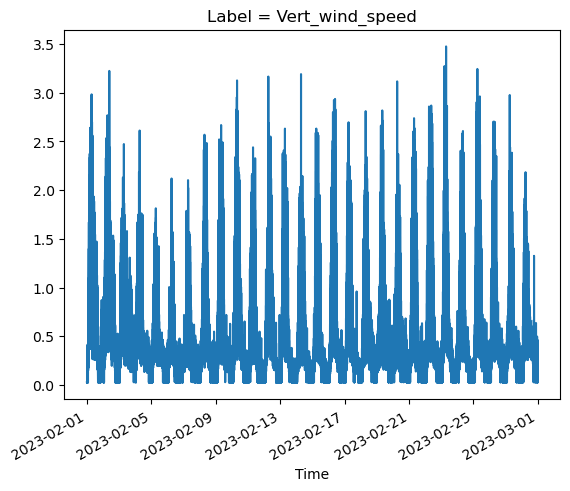

In [42]:
U_0_cleaned = remove_outliers(U_0,1,99)
U_0_ms = U_0_cleaned*(10/36)
U_0_mean = rolling_window_mean(U_0_ms,'time',300)
w_surf_cleaned = remove_outliers(w_surf[:,0],1,99)
w_surf_mean = rolling_window_mean(w_surf_cleaned,'Time',60)[::60]

In [44]:
# T[:,:].drop_sel({"h_agl":0})

In [31]:
h_agl_ar_T = T_prof.h_agl
len_h_T = len(h_agl_ar_T)

# Creating a date range 
start_date = '2023-02-01'
end_date = '2023-03-28'

time = pd.date_range(start=start_date, end=end_date,freq='30s')
len_time = len(time)
time_IST = pd.date_range(start=start_date, end=end_date,freq='30s',tz='-0300')
# time_IST= time_IST.tz_localize(None)

T = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
q = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))



surf_T = xr.DataArray(np.zeros(shape=(len_time,1)),coords={'time': time, 'h_agl':[2]},dims=('time', 'h_agl'))
surf_q = xr.DataArray(np.zeros(shape=(len_time,1)),coords={'time': time, 'h_agl':[2]},dims=('time', 'h_agl'))
surf_P = xr.DataArray(np.zeros(shape=(len_time,1)),coords={'time': time, 'h_agl':[2]},dims=('time', 'h_agl'))


surf_T[:,0] = surf_T1[:].interp(time=time,method="linear")
surf_q[:,0] = Abs_q[:,0].interp(time=time,method="linear")
surf_P[:,0] = Pnot[:].interp(time=time,method="linear")




for h in range(len_h_T):
    
    T_intp = T_prof[:,h].dropna('time').interp(time=time,method="linear")
    T[:,h] = T_intp
    
    q_intp = Abs_q[:,h].dropna('time').interp(time=time,method="linear")
    q[:,h] = q_intp
    

In [32]:
# q_c.transpose().plot()

In [33]:
T_c = xr.concat([surf_T, T],dim='h_agl')
T_c = T_c.drop_sel({"h_agl": 0})
q_c = xr.concat([surf_q, q],dim='h_agl')
q_c = q_c.drop_sel({"h_agl": 0})

h_agl_ar_Tc = T_c.h_agl
len_h_Tc = len(h_agl_ar_Tc)

In [34]:
# Define the user-defined date and time range
# Creating a date range 
start_date = '2023-02-01'
end_date = '2023-02-28'
start_time = '01:00:01'
end_time = '23:59:00'

# Convert start and end dates and times to Pandas datetime objects
start_datetime = pd.to_datetime(start_date + ' ' + start_time)
end_datetime = pd.to_datetime(end_date + ' ' + end_time)

# Select data for the specified date and time range
try:
    T_selected_data = T_c.sel(time=slice(start_datetime, end_datetime))
#     theta_selected_data = theta.sel(time=slice(start_datetime, end_datetime))    
    q_selected_data = q_c.sel(time=slice(start_datetime, end_datetime))
    U_selected_data = U_0.sel(time=slice(start_datetime, end_datetime))
    UDir_selected_data = UDir.sel(time=slice(start_datetime, end_datetime))
    surf_P_selected_data = surf_P.sel(time=slice(start_datetime, end_datetime))
    LWP_selected_data = water_cont.sel(time=slice(start_datetime, end_datetime))
except KeyError:
    print("No data found in the specified date and time range.")

In [35]:

%matplotlib qt
plt.figure()
# plt.plot(theta_selected_data[:,0].time,theta_selected_data[:,0])
# plt.plot(theta_selected_data[:,1].time,theta_selected_data[:,5])
# plt.plot(theta_selected_data[:,1].time,theta_selected_data[:,10])
plt.plot(T_selected_data[:,1].time,T_selected_data[:,0])
# plt.plot(LWP_selected_data[:].time,LWP_selected_data[:])


In [37]:
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
ax1.plot(U_selected_data[:].time,U_selected_data[:]*10, color='blue', label='WS')
ax1.plot(UDir_selected_data[:].time,UDir_selected_data[:], color='red', label='WD')
ax1.set_xlabel('t')
# ax1.set_ylabel('Sin(x)', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis and plot the second dataset
ax2 = ax1.twinx()
# ax2.plot(surf_P_selected_data[:].time,surf_P_selected_data[:], color='black', label='Pres')
# ax2.set_ylabel('Exp(x)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Title
plt.title('Plot with Two Y-Axes')

Text(0.5, 1.0, 'Plot with Two Y-Axes')

In [63]:
#fucntion to seprate into mean and fluctuating parts
 
def mean_and_fluctuating_components(data_array, window_size):
    """
    Separate the mean and fluctuating components of a time series using a rolling window.

    Parameters:
        data_array (xarray.DataArray): Input DataArray time series.
        window_size (int): Size of the rolling window.

    Returns:
        xarray.DataArray, xarray.DataArray: Mean and fluctuating components.
    """
    # Compute rolling mean
    
    axis_name = data_array.dims[0]
    rolling_mean = data_array.rolling({axis_name: window_size}, center=True, min_periods=1).mean()
    
    # Compute fluctuating component
    fluctuating_component = data_array - rolling_mean
    
    return rolling_mean, fluctuating_component


In [66]:
w0bar,w0_pert = mean_and_fluctuating_components(w_surf_cleaned,60)
w0bar.plot()

In [95]:
ubar,u_pert = mean_and_fluctuating_components(cleaned_u,600)
vbar,v_pert = mean_and_fluctuating_components(cleaned_v,600)
wbar,w_pert = mean_and_fluctuating_components(cleaned_w,600)

In [97]:
w_pert[:,:].transpose().plot()
# plt.figure()
# u_mean1[:,:].transpose().plot()

In [88]:
#interpolations and error removal
h_indx1 = 0
h_indx2 = 50

h_agl_ar = w.h_agl[h_indx1:h_indx2]

len_h = len(h_agl_ar)

u_pert1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
u_mean1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

# v_pert = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
# v_mean = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

# w_pert = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
# w_mean = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))


for h1 in range(len_h):
    
    h = h_indx1+h1

#     umax_thres = u[:,h].quantile(0.99) ##
#     umin_thres = u[:,h].quantile(0.05)

#     vmax_thres = v[:,h].quantile(0.99)
#     vmin_thres = v[:,h].quantile(0.05)## For fluctuations

#     wmax_thres = w[:,h].quantile(0.99)
#     wmin_thres = w[:,h].quantile(0.01) ##


#     u[:,h][u[:,h]>umax_thres] = np.nan ## for fluctuations
#     u[:,h][u[:,h]<umin_thres] = np.nan
#     v[:,h][v[:,h]>vmax_thres] = np.nan
#     v[:,h][v[:,h]<vmin_thres] = np.nan
#     w[:,h][w[:,h]>wmax_thres] = np.nan
#     w[:,h][w[:,h]<wmin_thres] = np.nan
    
    u_intp = cleaned_u[:,h].dropna('time').interp(time=time,method="linear") #use quantile on raw data itself
#     v_intp = cleaned_v[:,h].dropna('time').interp(time=time,method="linear")
#     w_intp = cleaned_w[:,h].dropna('time').interp(time=time,method="linear")

    u_roll = u_intp[:].rolling(time=30,center=True).mean()
#     v_roll = v_intp[:].rolling(time=30,center=True).mean()
#     w_roll = w_intp[:].rolling(time=30,center=True).mean()

    u_det = u_intp - u_roll

#     v_det = v_intp - v_roll
#     w_det = w_intp - w_roll
    
#     ##########################################################
    
#     umax_thres = u_det.quantile(0.985) ##
#     umin_thres = u_det.quantile(0.03)
    
#     vmax_thres = v_det.quantile(0.989)
#     vmin_thres = v_det.quantile(0.03)## For fluctuations
    
#     wmax_thres = w_det.quantile(0.995)
#     wmin_thres = w_det.quantile(0.005) ##

    
#     u_det[u_det>umax_thres] = np.nan ## for fluctuations
#     u_det[u_det<umin_thres] = np.nan
#     v_det[v_det>vmax_thres] = np.nan
#     v_det[v_det<vmin_thres] = np.nan
#     w_det[w_det>wmax_thres] = np.nan
#     w_det[w_det<wmin_thres] = np.nan
    
    
    u_pert1[:,h1] = u_det
    u_mean1[:,h1] = u_roll
#     v_pert[:,h1] = v_det
#     v_bar[:,h1] = v_roll
#     w_pert[:,h1] = w_det
#     w_bar[:,h1] = w_roll

In [92]:
u_mean1.plot()

In [473]:
u_mean1 = u_mean.rolling(time=20,center=True).mean()[::20]
v_mean1 = v_mean.rolling(time=20,center=True).mean()[::20]

In [474]:
wd = 90- ((np.arctan(v_mean1[:,:]/u_mean1[:,:]))*(180/3.14))
wd.rolling(time=20,center=True).mean().transpose().plot()

In [475]:
U = (u_mean1**2 + v_mean1**2)**0.5
U[:].rolling(time=10,center=True).mean().transpose().plot(robust=True)

In [476]:
w_pert[:,:].transpose().plot()
# v_mean[:,5].transpose().plot()
# w_mean[:,5].transpose().plot()

In [324]:
v_pert.plot.hist(bins=100)

(array([3.46000e+02, 9.37000e+02, 1.54800e+03, 2.06800e+03, 2.81600e+03,
        3.17800e+03, 3.83600e+03, 4.34900e+03, 5.00400e+03, 5.60700e+03,
        6.55900e+03, 7.49600e+03, 8.50400e+03, 9.39300e+03, 1.03260e+04,
        1.13590e+04, 1.21480e+04, 1.34770e+04, 1.46240e+04, 1.60440e+04,
        1.76510e+04, 1.92630e+04, 2.10760e+04, 2.31320e+04, 2.53330e+04,
        2.80480e+04, 3.10270e+04, 3.47950e+04, 3.88570e+04, 4.37450e+04,
        4.95440e+04, 5.67900e+04, 6.49800e+04, 7.53270e+04, 8.78230e+04,
        1.03332e+05, 1.23934e+05, 1.48417e+05, 1.77239e+05, 2.08952e+05,
        7.75646e+05, 2.41715e+05, 1.90540e+05, 1.57787e+05, 1.31565e+05,
        1.09611e+05, 9.28520e+04, 7.88220e+04, 6.79810e+04, 5.87800e+04,
        5.10490e+04, 4.49170e+04, 4.02360e+04, 3.58900e+04, 3.22720e+04,
        2.94710e+04, 2.64300e+04, 2.40120e+04, 2.20990e+04, 2.03250e+04,
        1.85450e+04, 1.72550e+04, 1.59140e+04, 1.45270e+04, 1.35620e+04,
        1.25720e+04, 1.16100e+04, 1.09260e+04, 1.00

In [237]:
u_pert1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
v_pert1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
w_pert1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

u_mean1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
v_mean1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))
w_mean1 = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

for h in range(len_h):
    
    u_intp = u_pert[:,h].dropna('time').interp(time=time,method="linear")
    v_intp = v_pert[:,h].dropna('time').interp(time=time,method="linear")
    w_intp = w_pert[:,h].dropna('time').interp(time=time,method="linear")
    
    u_intp1 = u_mean[:,h].dropna('time').interp(time=time,method="linear")
    v_intp1 = v_mean[:,h].dropna('time').interp(time=time,method="linear")
    w_intp1 = w_mean[:,h].dropna('time').interp(time=time,method="linear")
    
    
    u_pert1[:,h] = u_intp
    v_pert1[:,h] = v_intp
    w_pert1[:,h] = w_intp
    
#     u_mean1[:,h] = u_intp1
#     v_mean1[:,h] = v_intp1
#     w_mean1[:,h] = w_intp1

u_pert1 = u_pert1.rolling(time=5,center=True).mean()[::5]
v_pert1 = v_pert1.rolling(time=5,center=True).mean()[::5]
w_pert1 = w_pert1.rolling(time=5,center=True).mean()[::5]

# u_mean = u_pert1.rolling(time=6,center=True).mean()
    
# U = (u_mean1**2 + v_mean1**2)**0.5
# U = U.rolling(time=10,center=True).mean()[::10]

In [240]:
(w_pert - w_pert1).transpose().plot()

In [35]:
# w_pert1.plot.hist(bins=100)

# xarray creation function

In [325]:
def create_xarray_da(name,time,h_agl_ar):
    
    len_time = len(time)
    len_h = len(h_agl_ar)
    
    # Create xarray data array with the provided name as coordinate names
    data = np.zeros(shape=(len_time,len_h))
    da = xr.DataArray(data, dims=('time', 'h_agl'), coords={'time': time, 'h_agl': h_agl_ar, 'name': name})

    return da

In [ ]:
h_agl_ar_T

# Radiometer data processing

In [336]:
#interpolations and error removal
h_indx1 = 0
h_indx2 = 93

# T1 = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
Abs_q1 = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
    
# T_pert = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
# Abs_q_pert = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
# T_mean = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
# Abs_q_mean = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
p = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
theta = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
# rho_cp = xr.DataArray(np.zeros(shape=(len_time,len_h_T)),coords={'time': time, 'h_agl':h_agl_ar_T},dims=('time', 'h_agl'))
# Rainflag = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))
# Rainflag = RF[:].interp(time=time,method="nearest")
# Wat_cont = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))
# Wat_cont = water_cont[:].interp(time=time,method="nearest")
# lw_down = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))
# lw_down = LWD[:,4].interp(Time=time,method="nearest")
# Rel_q = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

R = 286.9
g = 9.81
cp = 1005


for h in range(len_h_Tc):
    
    Pnot_intp = Pnot.interp(time=time,method="linear")
    pres = Pnot_intp*np.exp(-((g*h_agl_ar_Tc[h])/(R*T_c[:,h])))

    p[:,h] = pres
    pot_temp = T_c[:,h]*((Pnot_intp/pres)**0.286)
    theta[:,h] = pot_temp

    
#     Abs_q_intp = Abs_q[:,h].dropna('time').interp(time=time,method="linear")
    
#     Abs_q1[:,h] = Abs_q_intp
                       

#     T_roll = T_intp[:].rolling(time=30,center=True).mean()
#     Abs_q_roll = Abs_q_intp[:].rolling(time=30,center=True).mean()
    
#     ###################################################
    
#     T_det = T_intp - T_roll
#     Abs_q_det =Abs_q_intp - Abs_q_roll
    
#     Tmax_thres = T_det.quantile(0.99)
#     Tmin_thres = T_det.quantile(0.01)
#     Abs_qmax_thres = Abs_q_det.quantile(0.99)
#     Abs_qmin_thres = Abs_q_det.quantile(0.01)
    
#     T_det[T_det>Tmax_thres] = np.nan
#     T_det[T_det<Tmin_thres] = np.nan
#     Abs_q_det[Abs_q_det>Abs_qmax_thres] = np.nan
#     Abs_q_det[Abs_q_det<Abs_qmin_thres] = np.nan
    
#     T_pert[:,h] = T_det
#     Abs_q_pert[:,h] = Abs_q_det
#     ################################################
# #     Tmax_thres = T_roll.quantile(0.99)
# #     Tmin_thres = T_roll.quantile(0.01)
# #     Abs_qmax_thres = Abs_q_roll.quantile(0.99)
# #     Abs_qmin_thres = Abs_q_roll.quantile(0.01)
    
# #     T_roll[T_roll>Tmax_thres] = np.nan
# #     T_roll[T_roll<Tmin_thres] = np.nan
# #     Abs_q_roll[Abs_q_roll>Abs_qmax_thres] = np.nan
# #     Abs_q_roll[Abs_q_roll<Abs_qmin_thres] = np.nan
    
#     T_mean[:,h] = T_roll
#     pres = Pnot_intp*np.exp(-((g*h_agl_ar_T[h])/(R*T1[:,h])))
# #     print(pres)
#     p[:,h] = pres
#     pot_temp = T_intp*((Pnot_intp/pres)**0.286)
#     theta[:,h] = pot_temp
#     Abs_q_mean[:,h] = Abs_q_roll
#     rho_cp[:,h] = (p[:,h]*100/(R*T_mean[:,h]))*1005



In [337]:
# theta_wc = theta.interp(h_agl=h_agl_ar,method="linear")
theta.transpose().plot()

In [351]:
theta_pert = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
theta_mean = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
Abs_q_pert = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))
Abs_q_mean = xr.DataArray(np.zeros(shape=(len_time,len_h_Tc)),coords={'time': time, 'h_agl':h_agl_ar_Tc},dims=('time', 'h_agl'))


for h in range(len_h_Tc):
    
#     theta_intp = theta11[:,h].dropna('time').interp(time=time,method="linear")
    theta_roll = theta[:,h].rolling(time=20,center=True).mean()
    theta_det = theta[:,h] - theta_roll
    theta_pert[:,h] = theta_det
    theta_mean[:,h] = theta_roll
                          
#     Abs_q_intp = Abs_q[:,h].dropna('time').interp(time=time,method="linear")
#     Abs_q_roll = Abs_q11[:,h].rolling(time=60,center=True).mean()
#     Abs_q_det = Abs_q11[:,h] - Abs_q_roll
#     Abs_q_pert[:,h] = Abs_q_det
#     Abs_q_mean[:,h] = Abs_q_roll

In [353]:
# theta[:,0].plot()
theta_mean[:,80].plot()
theta_mean[:,70].plot()

In [339]:
theta_pert[:,:].transpose().plot(robust=True)

In [335]:
theta_pert.time

<xarray.DataArray 'time' (time: 83521)>
array(['2022-04-01T00:00:00.000000000', '2022-04-01T00:00:30.000000000',
       '2022-04-01T00:01:00.000000000', ..., '2022-04-29T23:59:00.000000000',
       '2022-04-29T23:59:30.000000000', '2022-04-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01 2022-04-01T00:00:30 ... 2022-04-30

In [27]:
#kinematic fluxes
window_time = 10

upwp = u_pert1*w_pert1.rolling(time=window_time,center=True).mean()[::window_time]
vpwp = v_pert1*w_pert1.rolling(time=window_time,center=True).mean()[::window_time]
wpthetap = w_pert1*theta_pert.rolling(time=window_time,center=True).mean()[::window_time]


u_pert_sqr = u_pert1*u_pert1
# u_SD   = u_pert_sqr.rolling(time=30,center=True).std()
v_pert_sqr = v_pert1*v_pert1
# v_SD   = v_pert_sqr.rolling(time=30,center=True).std()
w_pert_sqr = w_pert1*w_pert1
TKE = (u_pert_sqr + v_pert_sqr + w_pert_sqr)/2
wpTKEp = w_pert1*TKE.rolling(time=window_time,center=True).mean()[::window_time]

u_var  = u_pert_sqr.rolling(time=window_time,center=True).mean()[::window_time]

v_var  = v_pert_sqr.rolling(time=window_time,center=True).mean()[::window_time]

w_var = w_pert_sqr.rolling(time=window_time,center=True).mean()[::window_time]

for h in range(len_h):
    u_var[:,h][u_var[:,h]<0]=np.nan
    v_var[:,h][v_var[:,h]<0]=np.nan
    w_var[:,h][w_var[:,h]<0]=np.nan ## removing negative values from variance

TKE = (u_var+v_var+w_var)/2

In [70]:
# wpTKEp[3500:7500].transpose().plot(robust=True,cmap='seismic')

# lowess Smoothing function

In [28]:
import statsmodels.api as sm

def lowess_smoothing(da, frac):
    smoothed_data = np.zeros_like(da)

    for i, t in enumerate(da['time']):
        y = da.sel(time=t)
        
        # Perform LOWESS smoothing
        lowess_result = sm.nonparametric.lowess(y.values, y.h_agl, frac=frac)
        smoothed_data[i, :] = lowess_result[:, 1]

    return xr.DataArray(smoothed_data, dims=('time', 'h_agl'), coords={'time': da['time'], 'h_agl': da['h_agl']})

# Apply LOWESS smoothing
# da = TKE[3500:7500,:]
# TKE_sm = lowess_smoothing(TKE[3500:7500,:], frac=0.2)

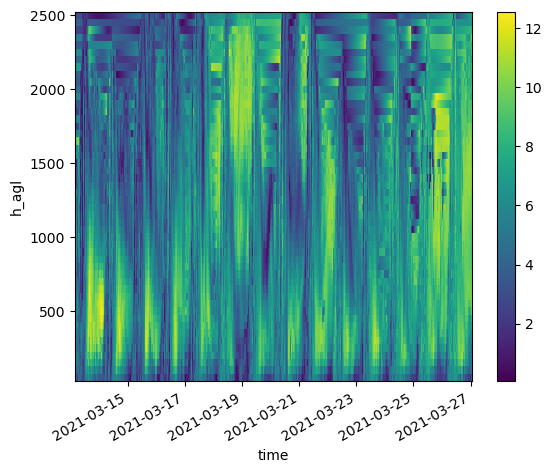

In [29]:
U[3500:7500,:].transpose().plot()

In [30]:
u_pert1[37440:66241,:].time
# u_pert1[34560:66241,:].transpose().plot()

<xarray.DataArray 'time' (time: 28801)>
array(['2021-03-14T00:00:00.000000000', '2021-03-14T00:00:30.000000000',
       '2021-03-14T00:01:00.000000000', ..., '2021-03-23T23:59:00.000000000',
       '2021-03-23T23:59:30.000000000', '2021-03-24T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-03-14 2021-03-14T00:00:30 ... 2021-03-24

In [81]:
import concurrent.futures
## lowess but with iterations

import xarray as xr
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
comp_t = 10

u_pert11 = u_pert1[37440:66241,:].rolling(time=10,center=True).mean()[::10]
v_pert11 = v_pert1[37440:66241,:].rolling(time=10,center=True).mean()[::10]

u_data_values = np.array(u_pert11[1:-1])
v_data_values = np.array(v_pert11[1:-1])
time_values = u_pert11[1:-1].time
h_agl_values = u_pert11.h_agl
# Create coordinates
coords = {'time': time_values, 'h_agl': h_agl_values}

# Initialize smoothed data
u_smoothed_data = u_data_values.copy()
v_smoothed_data = v_data_values.copy()

# Number of iterations
num_iterations = 3

def smooth_data(i):
    u_smoothed = sm.nonparametric.lowess(u_smoothed_data[i, :], h_agl_values, frac=0.15)[:, 1]
    v_smoothed = sm.nonparametric.lowess(v_smoothed_data[i, :], h_agl_values, frac=0.15)[:, 1]
    return u_smoothed, v_smoothed

# Define the number of iterations and length of time_values
# num_iterations = ...
len_time_values = len(time_values)


# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit tasks for parallel execution
    futures = [executor.submit(smooth_data, i) for i in range(len_time_values)]
    
    # Retrieve results as they become available
    for i, future in enumerate(concurrent.futures.as_completed(futures)):
        u_smoothed_data[i, :], v_smoothed_data[i, :] = future.result()

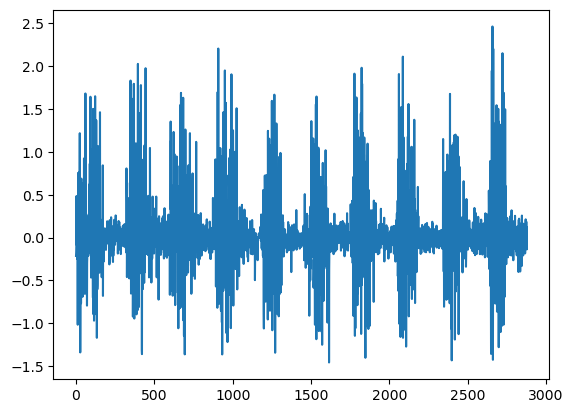

In [91]:
plt.plot(v_smoothed_data[:,5])

In [35]:
# ## lowess but with iterations

# import xarray as xr
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# comp_t = 10

# u_pert11 = u_pert1[37440:66241,:].rolling(time=10,center=True).mean()[::10]
# v_pert11 = v_pert1[37440:66241,:].rolling(time=10,center=True).mean()[::10]

# u_data_values = np.array(u_pert11[1:-1])
# v_data_values = np.array(v_pert11[1:-1])
# time_values = u_pert11[1:-1].time
# h_agl_values = u_pert11.h_agl
# # Create coordinates
# coords = {'time': time_values, 'h_agl': h_agl_values}

# # Number of iterations
# num_iterations = 3

# # Initialize smoothed data
# u_smoothed_data = u_data_values.copy()
# v_smoothed_data = v_data_values.copy()

# # Iterate the lowess smoothing process
# for _ in range(num_iterations):
#     for i in range(len(time_values)):
#         u_smoothed_data[i, :] = sm.nonparametric.lowess(u_smoothed_data[i, :], h_agl_values, frac=0.15)[:, 1]
#         v_smoothed_data[i, :] = sm.nonparametric.lowess(v_smoothed_data[i, :], h_agl_values, frac=0.15)[:, 1]


# # Create a new DataArray for the iteratively smoothed data
# u_smoothed_da = xr.DataArray(u_smoothed_data, coords=coords, dims=['time', 'h_agl'])
# v_smoothed_da = xr.DataArray(v_smoothed_data, coords=coords, dims=['time', 'h_agl'])

Text(0, 0.5, 'Data Values')

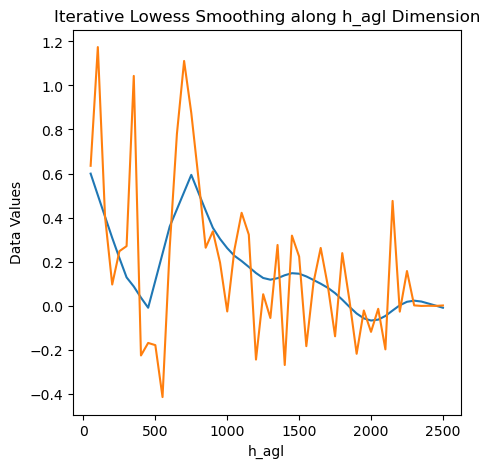

In [37]:
# Plot the original and iteratively smoothed data
plt.figure(figsize=(5, 5))
tt=1500
u_smoothed_da[tt-1,:].transpose().plot()
# plt.figure(figsize=(5, 5))
u_pert11[tt,:].transpose().plot()#66241
# plt.plot(h_agl_values, data_values[35000:40000, 0], label='Original Data', marker='o')
# plt.plot(h_agl_values, smoothed_data[:, 0], label=f'Smoothed Data (Iterations={num_iterations})', color='orange')
plt.title('Iterative Lowess Smoothing along h_agl Dimension')
plt.xlabel('h_agl')
plt.ylabel('Data Values')
# plt.legend()
# plt.show()

# gradient calculations for dissipation

In [38]:
dupdz = create_xarray_da('dupdz',u_smoothed_da.time,u_smoothed_da.h_agl)
d2updz2 = create_xarray_da('d2updz2',u_smoothed_da.time,u_smoothed_da.h_agl)
dvpdz = create_xarray_da('dvpdz',v_smoothed_da.time,v_smoothed_da.h_agl)
d2vpdz2 = create_xarray_da('d2vpdz2',v_smoothed_da.time,v_smoothed_da.h_agl)

u_mean11 = u_mean1.rolling(time=10,center=True).mean()[::10]
v_mean11 = v_mean1.rolling(time=10,center=True).mean()[::10]

dh=50
for t in range(len(u_smoothed_da)):
    dupdz[t,:] = np.gradient(u_smoothed_da[t,:],dh)
    d2updz2[t,:] = np.gradient(dupdz[t,:],dh)
    dvpdz[t,:] = np.gradient(v_smoothed_da[t,:],dh)
    d2vpdz2[t,:] = np.gradient(dvpdz[t,:],dh)

S1 = u_mean11*d2updz2
S2 = v_mean11*d2vpdz2
diss = 10**-5*(S1 + S2)

In [39]:
%matplotlib qt
(dupdz[tt,:]*150).plot()
u_smoothed_da[tt,:].plot()

In [140]:
dupdz.h_agl

<xarray.DataArray 'h_agl' (h_agl: 50)>
array([  50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.,
        550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,  950., 1000.,
       1050., 1100., 1150., 1200., 1250., 1300., 1350., 1400., 1450., 1500.,
       1550., 1600., 1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.,
       2050., 2100., 2150., 2200., 2250., 2300., 2350., 2400., 2450., 2500.])
Coordinates:
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03
    name     <U5 'dupdz'

In [41]:
diss[:,0].transpose().plot()

In [83]:
# d2updz2[:,:].transpose().plot(robust=True)

# nan count

In [701]:
# nan_count = u_pert11[1:-1].isnull().sum()
# nan_count
# u_pert11[1:-1].time
# u_pert1

<xarray.DataArray (time: 83521, h_agl: 50)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2021-03-01 2021-03-01T00:00:30 ... 2021-03-30
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

# set dates from 14 to 23 Mar 00 UTC to 00UTC

In [108]:
upwp_sm = lowess_smoothing(upwp[3744:6625,:], frac=0.2)
vpwp_sm = lowess_smoothing(vpwp[3744:6625,:], frac=0.2)
wpthetap_sm = lowess_smoothing(wpthetap[3744:6625,:], frac=0.2)
# TKE_sm = lowess_smoothing(TKE[5000:7500,:], frac=0.2)
wpTKEp_sm = lowess_smoothing(wpTKEp[3744:6625,:], frac=0.2)
U_sm=lowess_smoothing(U[3744:6625,:],frac=0.15)

In [308]:
# Plot original and smoothed data
%matplotlib qt
plt.figure(figsize=(12, 6))
U[3500:7500,:].transpose().plot(label='Original Data')
plt.figure(figsize=(12, 6))
U_sm.transpose().plot(label='LOWESS Smoothing',robust=True)
# plt.legend()

In [114]:
dEdt= create_xarray_da('dEdt',U_sm.time,h_agl_ar)
dUdz = create_xarray_da('dUdz',U_sm.time,h_agl_ar)
dwpEpdz = create_xarray_da('dwpEpdz',U_sm.time,h_agl_ar)
len_time1 = len(U_sm.time)


dt = 300
dh = 50

for h in range(len_h):
    dEdt[:,h] = np.gradient(TKE[3744:6625,h],dt)
#     del_theta_del_t[:,h] = np.gradient(theta_mean[:,h],dt)

for t in range(len_time1):
    dUdz[t,:] = np.gradient(U_sm[t,:],dh)
    dwpEpdz[t,:] = np.gradient(wpTKEp_sm[t,:],dh)

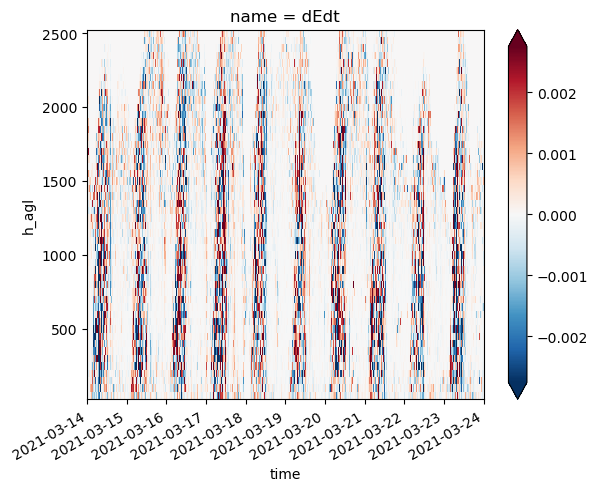

In [115]:
dEdt.transpose().plot(robust=True)

# TKE budget terms

# getting dissipation

In [478]:
%matplotlib qt

# u_pert_sm = lowess_smoothing(u_pert1[35000:75000,:],frac=0.17)
v_pert_sm = lowess_smoothing(v_pert1[35000:75000,:],frac=0.17)
v_pert_sm.transpose().plot(robust=True)

In [510]:
tt=1000
v_pert1[35000+tt,:].plot()
v_pert_sm[tt,:].plot()
# v_pert_roll[tt,:].plot()

In [511]:
# v_pert_roll = v_pert_sm.rolling(time=5,center=True).mean()
v_pert_sm[:,0].plot()
(v_pert1[35000:75000,0]+5).plot()

In [508]:
v_pert_roll.transpose().plot(robust=True)

In [156]:
from scipy.signal import welch
from scipy.fftpack import fft


# Generate a sample time series
# np.random.seed(42)
# time = np.linspace(0, 10, 1000)
# signal = np.sin(2 * np.pi * 1 * time) + 0.5 * np.random.randn(len(time))

# # Create a pandas DataFrame
# df = pd.DataFrame({'time': time, 'signal': signal})

# Calculate the power spectral density using Welch's method
frequencies, psd = welch(w_pert1[35340:36121,0], fs=1/30, nperseg=32)

# Plot the time series
plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(w_pert1[35340:36121,0].time,w_pert1[35340:36121,0])
# plt.title('Time Series')

# Plot the power spectral density
# plt.subplot(2, 1, 2)
plt.semilogy(frequencies, psd)
y=-5/3*frequencies + 80
plt.semilogy(frequencies, y)

plt.ylim(1,100)
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.tight_layout()

plt.show()


In [153]:
plt.semilogy(frequencies, y)
plt.semilogy(frequencies, psd)

<xarray.DataArray 'time' ()>
array('2022-03-13T07:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-03-13T07:30:00

In [770]:


%matplotlib qt
import matplotlib.dates as mdates
import matplotlib.lines as lines


size=14
# grid_lw = 1.5
lw=2

font1 = {'family':'serif','color':'black','size':18}
font2 = {'family':'serif','color':'black','size':14}

fig1= plt.figure(figsize=(16, 6), constrained_layout=True)

cmap = plt.colormaps['jet']

ax1 = fig1.add_axes([0.1,0.15,0.37,0.75])

ax1.scatter(w_prm_theta_prm_bar_smooth[292,:],w_prm_theta_prm_bar.h_agl)
ax1.scatter(w_prm_theta_prm_bar_smooth[292+1,:],w_prm_theta_prm_bar.h_agl)
ax1.scatter(w_prm_theta_prm_bar_smooth[292+4,:],w_prm_theta_prm_bar.h_agl)
ax1.scatter(w_prm_theta_prm_bar_smooth[292+8,:],w_prm_theta_prm_bar.h_agl)
ax1.scatter(w_prm_theta_prm_bar_smooth[292+12,:],w_prm_theta_prm_bar.h_agl)

ax1.set_ylabel(r'h(m)',fontdict=font1)
ax1.set_title('March 13, 2022', y=1, x=0.5,
             fontdict=font1)
ax1.tick_params(labelsize=size)
ax1.set_xlabel(r'$\overline{w^{\prime}\theta^{\prime}}$',fontdict = font2)

plt.legend(["1 PM IST","2 PM IST", "5 PM IST","9 PM IST","1 AM IST"],loc='upper right',fontsize=12)


ax2 = fig1.add_axes([0.55,0.15,0.37,0.75])

plt.scatter(w_prm_q_prm_bar_smooth[292,:],w_prm_theta_prm_bar_smooth.h_agl)
plt.scatter(w_prm_q_prm_bar_smooth[292+1,:],w_prm_theta_prm_bar_smooth.h_agl)
plt.scatter(w_prm_q_prm_bar_smooth[292+4,:],w_prm_theta_prm_bar_smooth.h_agl)
plt.scatter(w_prm_q_prm_bar_smooth[292+8,:],w_prm_theta_prm_bar_smooth.h_agl)
plt.scatter(w_prm_q_prm_bar_smooth[292+12,:],w_prm_theta_prm_bar_smooth.h_agl)

ax2.set_ylabel(r'h(m)',fontdict=font1)
ax2.set_title('March 13, 2022', y=1, x=0.5,
             fontdict=font1)
ax2.tick_params(labelsize=size)
ax2.set_xlabel(r'$\overline{w^{\prime}q^{\prime}}$',fontdict = font2)
plt.legend(["1 PM IST","2 PM IST", "5 PM IST","9 PM IST","1 AM IST"],loc='upper left',fontsize=12)

# plt.savefig("D:/figures/Y2022/M03/13_march_temp_moisture_flux_vsh.pdf",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

# plt.savefig("D:/figures/Y2022/M03/13_march_temp_moisture_flux_vsh.png",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')


In [723]:
w_prm_theta_prm_bar_smooth[297,:].time

<xarray.DataArray 'time' ()>
array('2022-03-07T08:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-03-07T08:00:00

In [569]:
plt.figure()
w_prm_theta_prm_bar_smooth[970,:].plot()
w_prm_q_prm_bar_smooth[970,:].plot()
(10*dthetadz_bar[970,:]).plot()

In [776]:
k_q = w_prm_q_prm_bar_smooth/del_q_del_z
k_theta = w_prm_theta_prm_bar_smooth/del_theta_del_z

In [784]:
k_q

<xarray.DataArray (time: 717, h_agl: 50)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,  0.53519831,
         0.13314267,  0.60319277],
       [        nan,         nan,         nan, ..., -0.39366275,
        -0.39417492, -0.73948453],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01T03:30:00 ... 2022-03-30T23:30:00
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

In [783]:
k_theta[:,:].transpose().plot()

In [788]:
R = k_q/k_theta
R_smooth = R.rolling(time=5,center=True).mean()
R_smooth = R_smooth.rolling(h_agl=3,center=True).mean()
R_smooth.transpose().plot(vmin=-10,vmax=10,cmap='seismic')

In [590]:
w_prm_theta_prm_bar.h_agl

<xarray.DataArray 'h_agl' (h_agl: 50)>
array([  50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.,
        550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,  950., 1000.,
       1050., 1100., 1150., 1200., 1250., 1300., 1350., 1400., 1450., 1500.,
       1550., 1600., 1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.,
       2050., 2100., 2150., 2200., 2250., 2300., 2350., 2400., 2450., 2500.])
Coordinates:
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

In [360]:
theta_mean.transpose().plot()

In [365]:
w_prm_q_prm[1000:7000].transpose().plot()

In [341]:
# plt.plot(theta_mean[10500,:],theta_mean.h_agl)
# plt.plot(T_mean[10500,:],theta_mean.h_agl)
# theta_mean[10500,:].time

In [40]:
# %matplotlib inline
# xr.plot.hist(theta_pert,bins=100)

# rho. C_p. delT/delz = k.delsqrT/delzsqr - radiative flux(dF/dz) 



In [793]:
del_theta_del_z[98:120,:].transpose().plot()

In [775]:
w_prm_q_prm_bar_smooth

<xarray.DataArray (time: 717, h_agl: 50)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.00164886,
        -0.00040281, -0.00180483],
       [        nan,         nan,         nan, ...,  0.00122956,
         0.00120683,  0.00223667],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01T03:30:00 ... 2022-03-30T23:30:00
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

In [773]:
del_theta_del_z[:,:].transpose().plot(vmin=-0.01,vmax=0.01,cmap='seismic')
(100+IWV_fluc[:]*50).plot()
(100+10*RR_smooth[:]).plot()

In [606]:

dqdz_bar = del_q_del_z[:].rolling(time=10,center=True).mean()
dthetadz_bar = del_theta_del_z[:].rolling(time=10,center=True).mean()

# plt.figure()
# del_theta_del_z.transpose().plot()
# plt.figure()
# dthetadz_bar.transpose().plot()

<xarray.DataArray (time: 1433, h_agl: 50)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01T03:30:00 ... 2022-03-30T23:30:00
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

# Richardson Number calc

In [309]:
# Ri=xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

# Ri = (g*(del_theta_del_z/theta))/((del_U_del_z)**2+(del_V_del_z)**2)

In [354]:
# Ri[t3:t4].transpose().plot(cmap='bwr')

SyntaxError: unmatched ')' (1984473022.py, line 1)

In [524]:
# del_T_del_t[t3:t4].transpose().plot()

In [123]:
day= 22

t1=400

time_gap=850

t2=t1+time_gap

# sunset_point= 270

t3 = t1 + (day-1)*1440 # day = 0 puts data from back
t4=t3+time_gap

k = 0.02624
rad_div = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

rad_div =  k*del_del_theta_del_z - rho_cp*del_theta_del_t#



In [124]:
rad_div[t3:t4,0:10].transpose().plot()
# lw_down[t3:t4].plot()

In [645]:
theta[t3+270].time

<xarray.DataArray 'time' ()>
array('2022-03-19T13:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-03-19T13:00:00

In [703]:
## plotiing colormaps for transtion time only

%matplotlib qt
import matplotlib.dates as mdates
import matplotlib.lines as lines


size=14
# grid_lw = 1.5
lw=2

font1 = {'family':'serif','color':'black','size':18}
font2 = {'family':'serif','color':'black','size':14}

fig1= plt.figure(figsize=(8, 6), constrained_layout=True)

cmap = plt.colormaps['jet']

#############################################

day=22

t1=300

time_gap=540

t2=t1+time_gap

sunset_point= 570

t3 = t1 + (day-1)*1440
t4=t3+time_gap

#     j=i+1

ax1 = fig1.add_axes([0.12,0.15,0.85,0.8])
# a= ax1.pcolormesh(np.array(theta.time[t1:t2]),np.array(theta.h_agl[0:53]),rad_div[t3:t4,:].transpose(),cmap=cmap)
# cbar = plt.colorbar(a,ax=ax1)
# ax1.set_xlabel(r'time(UTC)',fontdict = font2)
# cbar.ax.tick_params(labelsize=14)
# # cbar.set_label(label='$K$',size=size)
# #     ax.flat[0].set_ylim(0,1.5)
# ax1.vlines(np.array(theta.time[sunset_point]), 50, 2450,linestyles =("dashed"), colors =("brown"),lw=3)
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# ax1.set_ylabel(r'h(m)',fontdict=font1)
# ax1.set_title('Rad flux, LWD, IWP and RF', y=1, x=0.5,
#              fontdict=font1)
# ax1.tick_params(labelsize=12)
# for label in ax1.get_xticklabels(which='major'):
#     label.set(rotation=15, horizontalalignment='right',fontsize=size)
    
# ax11 = ax1.twinx()
# ax11.plot(np.array(theta.time[t1:t2]),lw_down[t3:t4],color='orange',lw=3)
# ax11.plot(np.array(theta.time[t1:t2]),(Rainflag[t3:t4]*60+360),color='pink',lw=3)
# ax11.plot(np.array(theta.time[t1:t2]),(Wat_cont[t3:t4]/10)+360,color='black',lw=1.5)
# ax11.set_yticks([])
# plt.text(-0.1,-0.15,'March 22, 2022', fontsize = 14, transform=ax11.transAxes)
    

# ############

ax2 = fig1.add_axes([0.55,0.55,0.45,0.37])
# a= ax2.pcolormesh(Abs_q_i.time[t1:t2],Abs_q_i.h_agl[0:53],Abs_q_i[t3:t4,0:53].transpose(),cmap=cmap)
# cbar = plt.colorbar(a,ax=ax2)
# # ax2.set_xlabel(r'time(UtC)',fontdict = font2)

# cbar.ax.tick_params(labelsize=14)
# cbar.set_label(label='$g/m^{2}$',size=size)
# #     ax.flat[0].set_ylim(0,1.5)
# ax2.vlines(Abs_q_i.time[sunset_point], 50, 2450,linestyles =("solid"), colors =("orange"),lw=3)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# ax2.tick_params(labelsize=12)
# ax2.set_title(r'$Q$', y=1, x=0.5,
#              fontdict=font1)
# for label in ax2.get_xticklabels(which='major'):
#     label.set(rotation=15, horizontalalignment='right',fontsize=size)

# ####

# ax3 = fig1.add_axes([0.06,0.07,0.45,0.37])
# a= ax3.pcolormesh(Rel_q_i.time[t1:t2],Rel_q_i.h_agl[0:53],Rel_q_i[t3:t4,0:53].transpose(),cmap=cmap)

# cbar = plt.colorbar(a,ax=ax3)
# cbar.ax.tick_params(labelsize=14)
# cbar.set_label(label='$\% $',size=size)
# ax3.set_xlabel(r'time(UTC)',fontdict = font2)
# #     ax.flat[0].set_ylim(0,1.5)
# ax3.vlines(Rel_q_i.time[sunset_point], 50, 2450,linestyles =("solid"), colors =("orange"),lw=3)
# ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# ax3.set_ylabel(r'h(m)',fontdict=font1)
# ax3.tick_params(labelsize=12)
# ax3.set_title(r'$q$', y=1, x=0.5,
#              fontdict=font1)

# for label in ax3.get_xticklabels(which='major'):
#     label.set(rotation=15, horizontalalignment='right',fontsize=size)
# ###############

# ax4 = fig1.add_axes([0.55,0.07,0.45,0.37])
# a= ax4.pcolormesh(T_i.time[t1:t2],T_i.h_agl[0:53],T_i[t3:t4,0:53].transpose(),cmap=cmap,)
# cbar = plt.colorbar(a,ax=ax4)
# cbar.ax.tick_params(labelsize=14)
# ax4.set_xlabel(r'time(UTC)',fontdict = font2)
# cbar.set_label(label='$K$',size=size)
# #     ax.flat[0].set_ylim(0,1.5)
# ax4.vlines(T_i.time[sunset_point], 50, 2450,linestyles =("solid"), colors =("orange"),lw=3)
# ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# ax4.tick_params(labelsize=12)
# ax4.set_title(r'$T$', y=1, x=0.5,
#              fontdict=font1)

# for label in ax4.get_xticklabels(which='major'):
#     label.set(rotation=15, horizontalalignment='right',fontsize=size)
    

###########################################################################################

# plt.savefig("D:/figures/Y2022/M03/22_march_radiative_ET.pdf",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

# plt.savefig("D:/figures/Y2022/M03/22_march_radiative_ET.png",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

In [595]:
Rainflag[t3:t4].time

<xarray.DataArray 'time' (time: 540)>
array(['2022-03-26T08:30:00.000000000', '2022-03-26T08:31:00.000000000',
       '2022-03-26T08:32:00.000000000', ..., '2022-03-26T17:27:00.000000000',
       '2022-03-26T17:28:00.000000000', '2022-03-26T17:29:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-03-26T08:30:00 ... 2022-03-26T17:29:00
Attributes:
    long_name:  sample time
    comment:    time is UTC

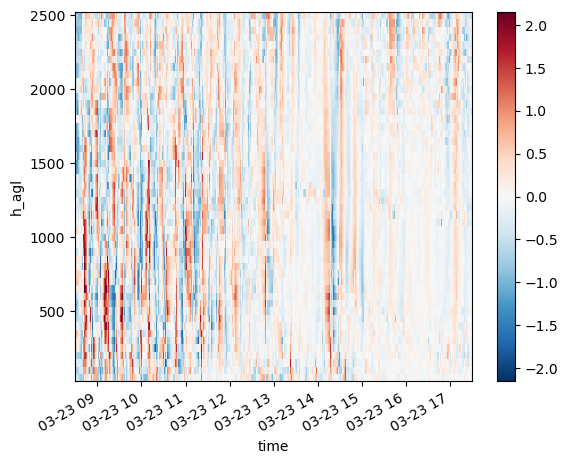

In [574]:
%matplotlib inline
# w_prm_q_prm[t3:t4].transpose().plot()
# Abs_q_pert1[t3:t4].transpose().plot()
w_pert1[t3:t4].transpose().plot()

In [49]:
Abs_q_pert[t3:t4,:].transpose().plot()

In [56]:
# T_pert[t3,:].transpose().plot()
plt.plot(Abs_q_pert[t3+200,:],Abs_q_pert.h_agl)

In [52]:
w_pert1[420:420+600].time

<xarray.DataArray 'time' (time: 600)>
array(['2021-04-01T07:30:00.000000000', '2021-04-01T07:31:00.000000000',
       '2021-04-01T07:32:00.000000000', ..., '2021-04-01T17:27:00.000000000',
       '2021-04-01T17:28:00.000000000', '2021-04-01T17:29:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-04-01T07:30:00 ... 2021-04-01T17:29:00

In [ ]:
# w_pert1.transpose().plot()

In [190]:
#10 min avgd buoyancy flux
# w_prm_T_prm_mean = xr.DataArray(np.zeros(shape=(len_time,len_h)),coords={'time': time, 'h_agl':h_agl_ar},dims=('time', 'h_agl'))

# for h in range(len_h):

#     w_prm_T_prm_intp = w_prm_T_prm[:,h].dropna('time').interp(time=time,method="linear")
#     w_prm_T_prm_roll = w_prm_T_prm_intp[:].rolling(time=10,center=True).mean()[::10]
#     w_prm_T_prm_mean[:,h] = w_prm_T_prm_roll
    
# w_prm_T_prm_mean.transpose().plot()

w_prm_theta_prm_avgd = w_prm_theta_prm[:].rolling(time=60,center=True).mean()[::60]

w_prm_q_prm_avgd = w_prm_q_prm[:].rolling(time=60,center=True).mean()[::60]
# w_prm_theta_prm_havgd = w_prm_theta_prm_avgd[:].rolling(h_agl=5,center=True).mean().dropna('h_agl')

In [193]:
w_prm_q_prm_avgd

<xarray.DataArray (time: 717, h_agl: 50)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.01187643,  0.00630842,  0.01278749, ...,         nan,
                nan,         nan],
       [-0.00137186, -0.02249187, -0.01992519, ...,         nan,
                nan,         nan],
       ...,
       [-0.00263164, -0.00123588, -0.00273444, ..., -0.00357575,
         0.00677138, -0.00400162],
       [-0.00293768,  0.00204717,  0.00065033, ..., -0.00063223,
         0.00258289,  0.00414859],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-01T03:30:00 ... 2022-03-30T23:30:00
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

In [197]:
w_prm_q_prm_avgd[151,0:25].transpose().plot()

In [114]:
%matplotlib qt

fig1 = plt.figure()
plt.plot(u_mean1[660,:],u_mean1.h_agl)
# u_mean1[660,:].time


fig2 = plt.figure()
day=10
plt.plot(w_prm_theta_prm_havgd[300+day*1440,:],w_prm_theta_prm_havgd.h_agl)
w_prm_theta_prm_havgd[300+day*1440,:].time

<xarray.DataArray 'time' ()>
array('2022-03-11T14:32:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-03-11T14:32:00

In [107]:
%matplotlib inline
# xr.plot.hist(w_prm_T_prm,bins=100)

In [366]:
#     wT_max_thres = T_roll.quantile(0.99)
#     wT_min_thres = T_roll.quantile(0.01)
#     wq_max_thres = Rel_q_roll.quantile(0.99)
#     wq_min_thres = Rel_q_roll.quantile(0.01)
    
#     T_roll[T_roll>Tmax_thres] = np.nan
#     T_roll[T_roll<Tmin_thres] = np.nan
#     Rel_q_roll[Rel_q_roll>Rel_qmax_thres] = np.nan
#     Rel_q_roll[Rel_q_roll<Rel_qmin_thres] = np.nan

In [756]:
w_prm_T_prm[0:0+540].time

<xarray.DataArray 'time' (time: 540)>
array(['2021-03-10T08:30:00.000000000', '2021-03-10T08:31:00.000000000',
       '2021-03-10T08:32:00.000000000', ..., '2021-03-10T17:27:00.000000000',
       '2021-03-10T17:28:00.000000000', '2021-03-10T17:29:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-03-10T08:30:00 ... 2021-03-10T17:29:00

# composite data analysis

In [1015]:
w_prm_T_prm_np = np.zeros(shape=(len_time,len_h), dtype=float)
w_prm_q_prm_np = np.zeros(shape=(len_time,len_h), dtype=float)
umean_np = np.zeros(shape=(len_time,len_h), dtype=float)
vmean_np = np.zeros(shape=(len_time,len_h), dtype=float)
# vwcomp_var_np = np.zeros(shape=(len_time,len_h), dtype=float)
# TKEcomp_np = np.zeros(shape=(len_time,len_h), dtype=float)


for day in range(21):
    
    day= day

    t1=0

    time_gap=540

    t2=t1+time_gap

    sunset_point= 270

    t3 = t1 + (day-1)*1440
    t4=t3+time_gap
    

    w_prm_T_prm_np[t1:t2,:] = (w_prm_T_prm_np[t1:t2,:] + w_prm_T_prm[t3:t4,:])
    w_prm_q_prm_np[t1:t2,:] = (w_prm_q_prm_np[t1:t2,:] + w_prm_q_prm[t3:t4,:])
    umean_np[t1:t2,:] = (umean_np[t1:t2,:] + u_mean1[t3:t4,:])
    vmean_np[t1:t2,:] = (vmean_np[t1:t2,:] + v_mean1[t3:t4,:])
#     vwcomp_var_np[t1:t2,:] = (vwcomp_var_np[t1:t2,:] + vw_bar[t3:t4,:])
#     TKEcomp_np[t1:t2,:] = (TKEcomp_np[t1:t2,:] + TKE[t3:t4,:])
    
w_prm_T_prm_np[t1:t2,:] = w_prm_T_prm_np[t1:t2,:]/day
w_prm_q_prm_np[t1:t2,:] = w_prm_q_prm_np[t1:t2,:]/day
umean_np[t1:t2,:] = umean_np[t1:t2,:]/day
vmean_np[t1:t2,:] = vmean_np[t1:t2,:]/day
# vwcomp_var_np[t1:t2,:] = vwcomp_var_np[t1:t2,:]/day
# TKEcomp_np[t1:t2,:]    = TKEcomp_np[t1:t2,:]/day

<Figure size 1600x600 with 0 Axes>

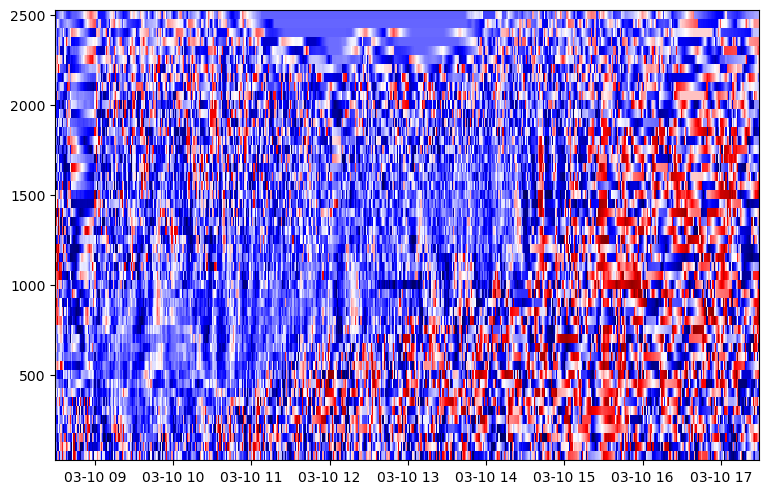

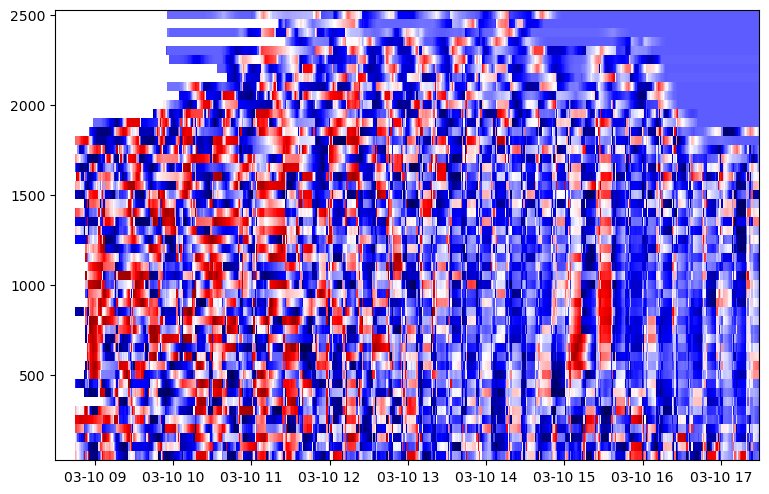

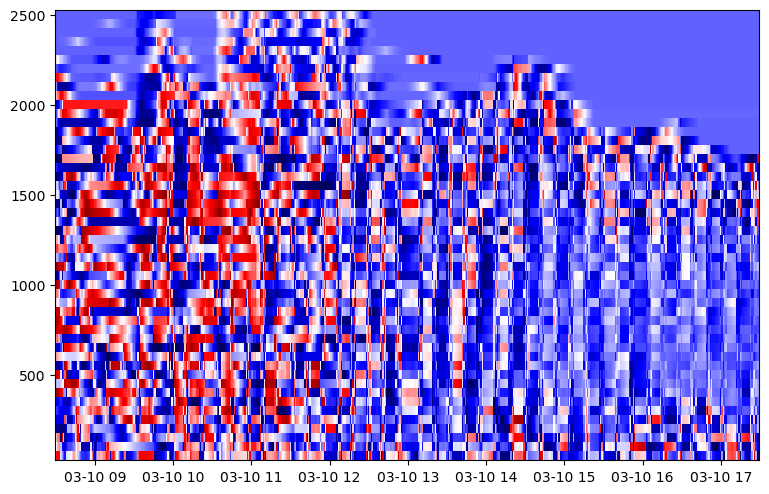

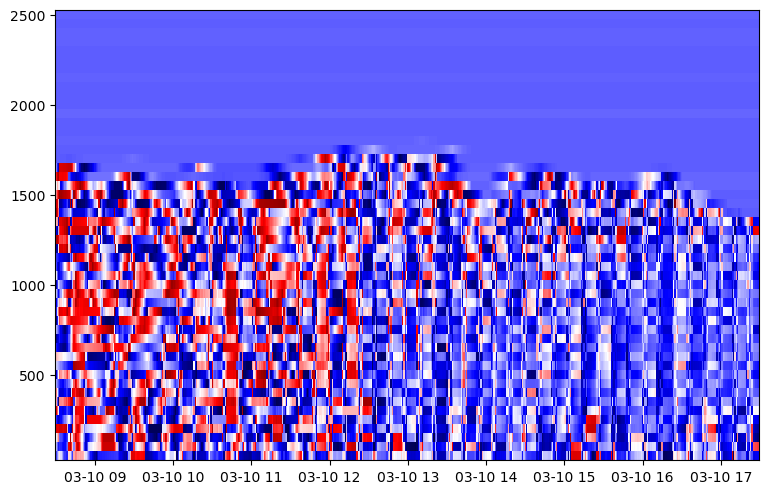

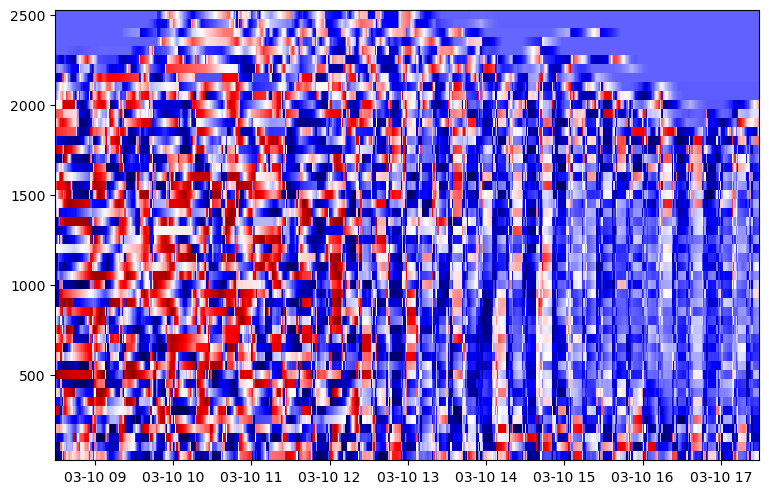

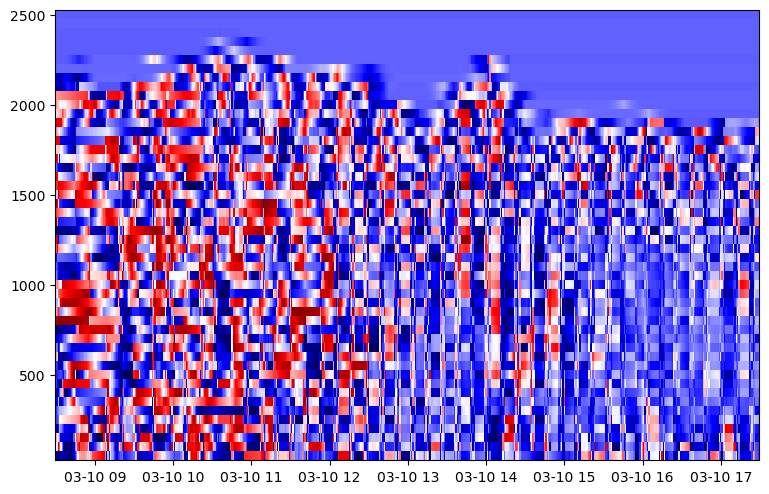

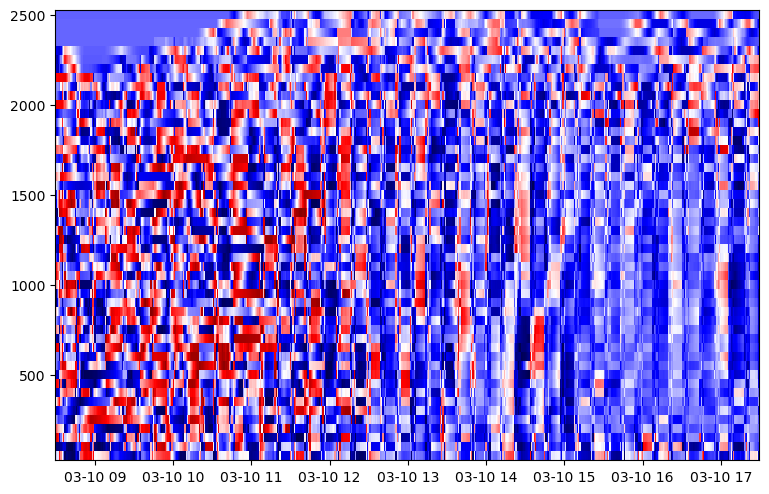

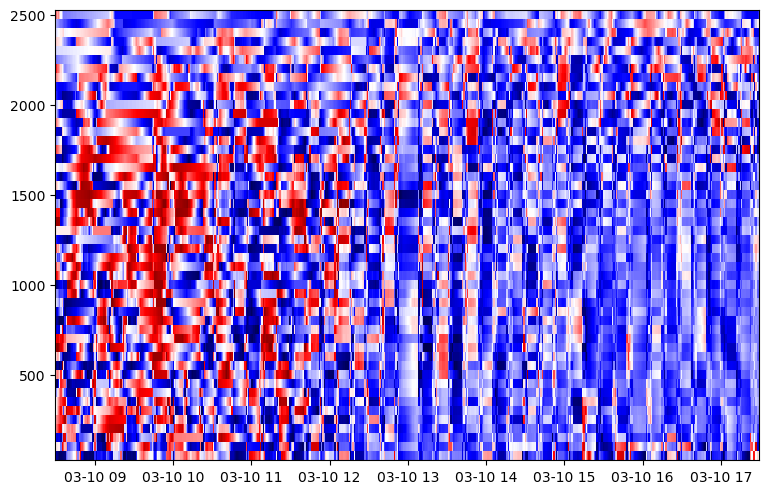

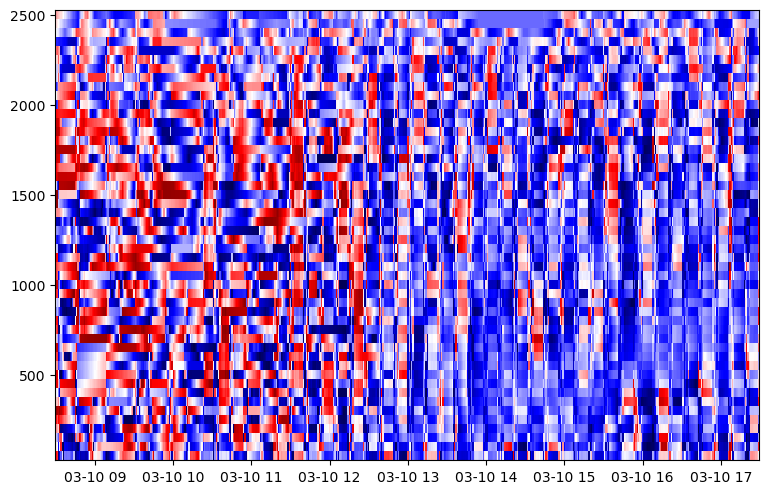

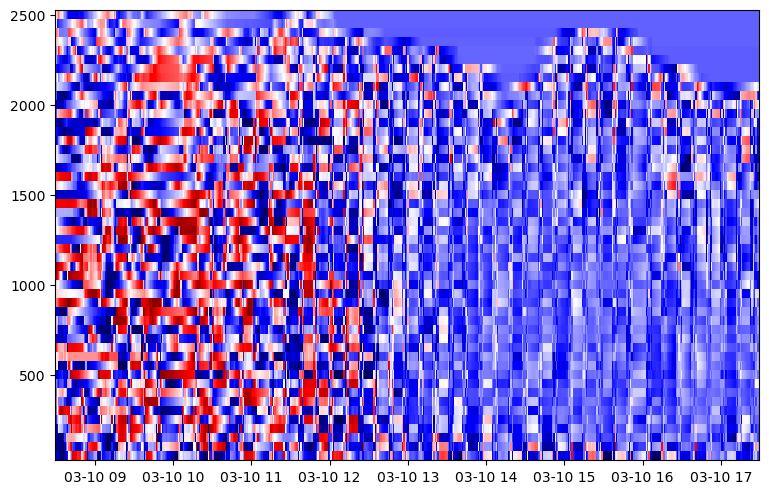

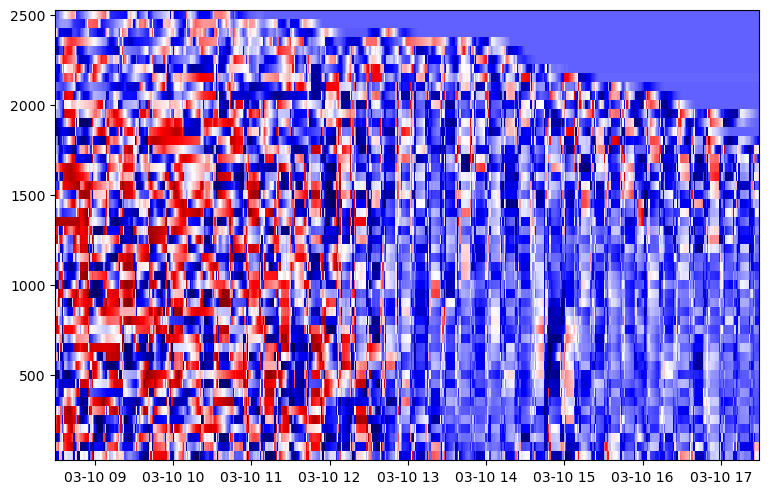

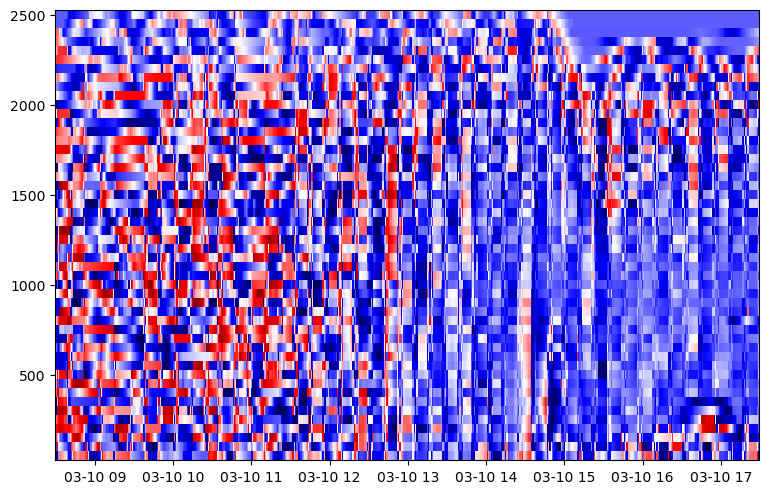

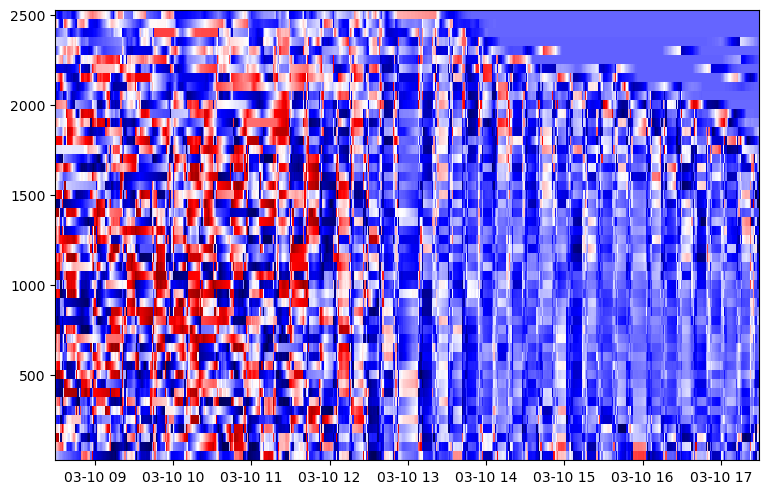

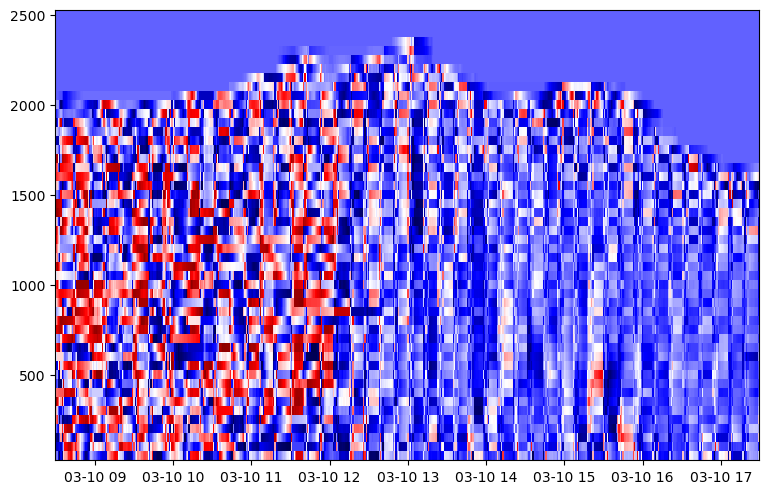

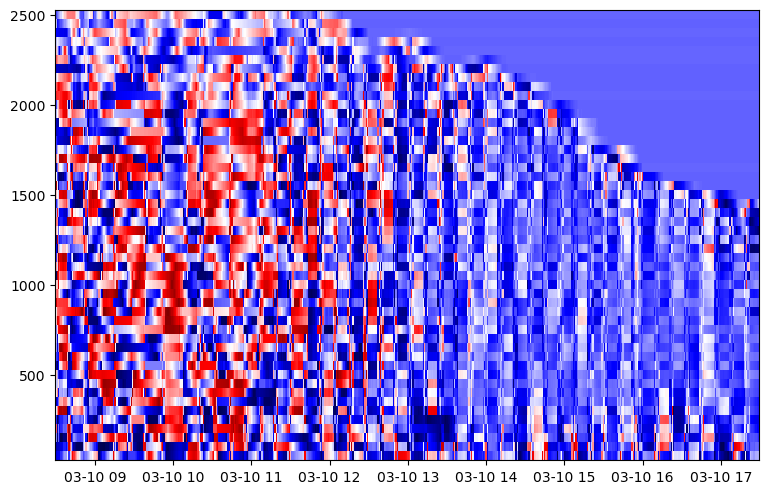

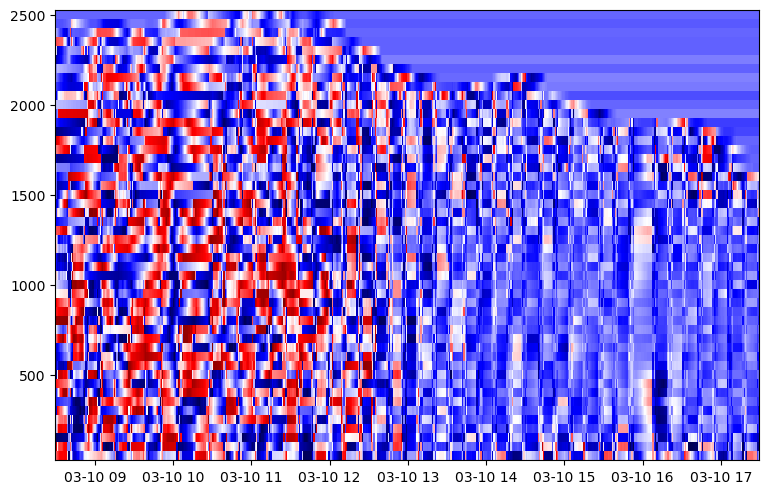

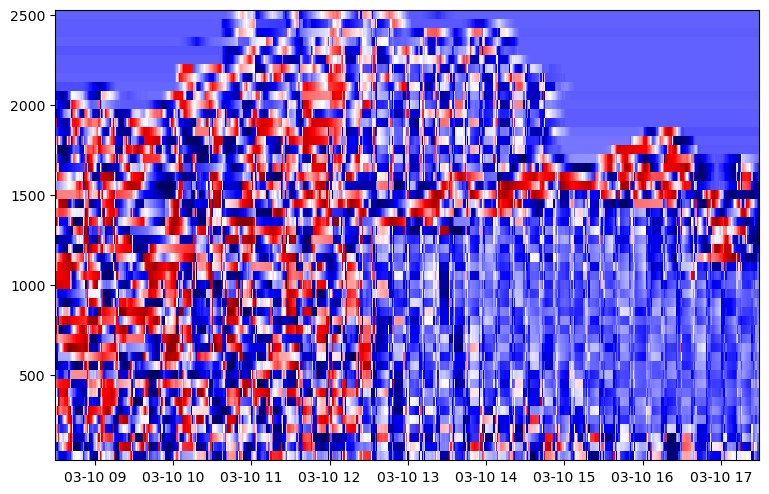

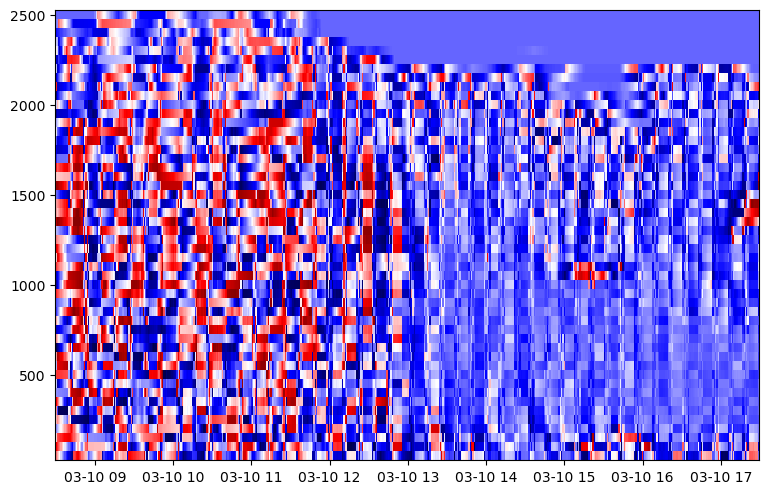

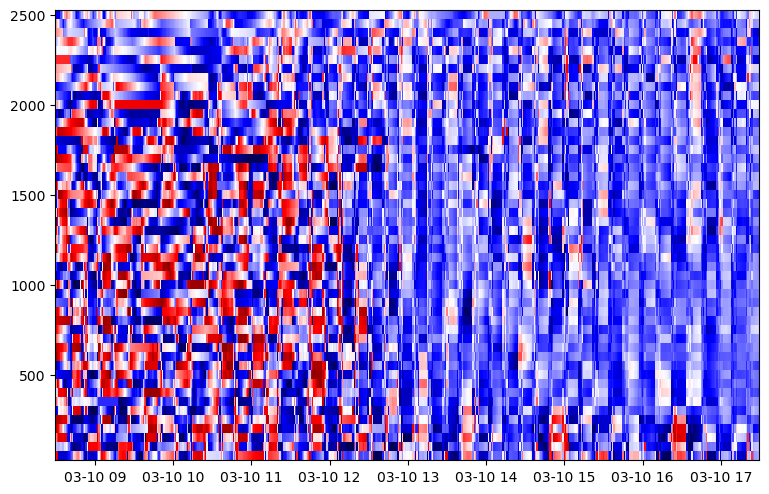

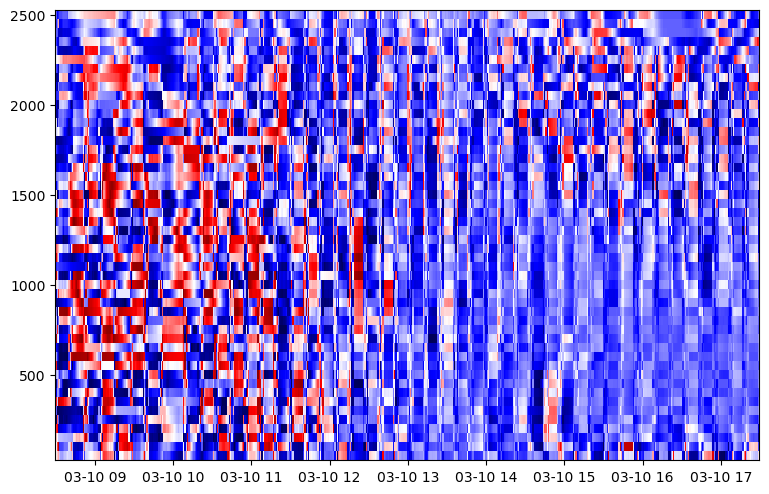

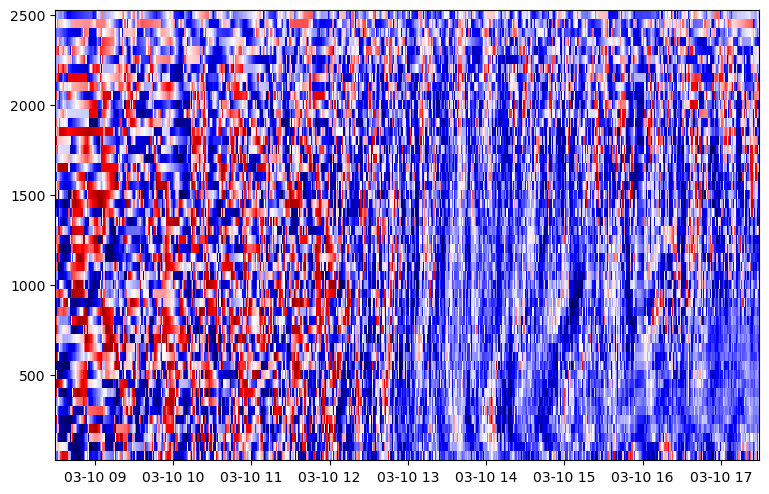

In [1099]:
#checking for days of cloud cover

# fig1= plt.figure(figsize=(16, 6), constrained_layout=True)

# cmap = plt.colormaps['seismic']


# for day in range(21):
#     fig1= plt.figure(figsize=(16, 6), constrained_layout=True)
    
#     day= day

#     t1=0

#     time_gap=540

#     t2=t1+time_gap

#     sunset_point= 270

#     t3 = t1 + (day-1)*1440
#     t4=t3+time_gap
#     ax1 = fig1.add_axes([0.06,0.15,0.44,0.75])
#     a= ax1.pcolormesh(np.array(w_prm_T_prm.time[t1:t2]),np.array(w_prm_T_prm.h_agl),u_pert1[t3:t4,:].transpose(),cmap=cmap)

    
    

In [1016]:
w_prm_q_prm[570].time

<xarray.DataArray 'time' ()>
array('2021-03-10T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-03-10T18:00:00

# Profiles of variables wrt h and t

In [655]:
%matplotlib qt
import matplotlib.dates as mdates
import matplotlib.lines as lines


size=15
# grid_lw = 1.5
lw=2

font1 = {'family':'serif','color':'black','size':18}
font2 = {'family':'serif','color':'black','size':14}

fig1= plt.figure(figsize=(16, 6), constrained_layout=True)

cmap = plt.colormaps['seismic']

#############################################


ax1 = fig1.add_axes([0.06,0.15,0.44,0.75])
a= ax1.pcolormesh(np.array(del_theta_del_z[50:500].time),np.array(del_theta_del_z.h_agl),del_theta_del_z[50:500,:].transpose(),cmap=cmap,vmin=-0.02,vmax=0.02)
cbar = plt.colorbar(a,ax=ax1)
# ax1.set_xlabel(r'time(UTC)',fontdict = font2)
cbar.ax.tick_params(labelsize=size)
cbar.set_label(label='$Km^{-1}$',size=size+3)
#     ax.flat[0].set_ylim(0,1.5)
# ax1.vlines(np.array(w_prm_T_prm.time[sunset_point]), 50, 2450,linestyles =("solid"), colors =("orange"),lw=3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax1.set_ylabel(r'AGL(m)',fontdict=font1)
ax1.set_title(r'$\frac{d\theta}{dz}$', y=1, x=0.5,
             fontdict=font1)
ax1.tick_params(labelsize=size)
ax1.set_xlabel(r'time(UTC)',fontdict = font2)
# ax1.set_xticks([])
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=15, horizontalalignment='right',fontsize=size)
    

# # # ############

ax2 = fig1.add_axes([0.54,0.15,0.44,0.75])
a= ax2.pcolormesh(np.array(del_q_del_z.time[50:500]),np.array(del_q_del_z.h_agl),del_q_del_z[50:500,:].transpose(),cmap=cmap,vmin=-0.02,vmax=0.02)
cbar = plt.colorbar(a,ax=ax2)
cbar.ax.tick_params(labelsize=size)
cbar.set_label(label='$gm^{-4}$',size=size+3)
#     ax.flat[0].set_ylim(0,1.5)
# ax2.vlines(np.array(w_prm_T_prm.time[sunset_point]), 50, 2450,linestyles =("solid"), colors =("orange"),lw=3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# ax1.set_ylabel(r'AGL(m)',fontdict=font1)
ax2.set_title(r'$\frac{dQ}{dz}$', y=1, x=0.5,
             fontdict=font1)
ax2.set_xlabel(r'time(UTC)',fontdict = font2)
ax2.set_yticks([])
ax2.tick_params(labelsize=size)
# ax1.set_xticks([])
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=15, horizontalalignment='right',fontsize=size)
    
# plt.suptitle("u_vel vs time at various height")

# ####

# plt.savefig("D:/figures/Y2022/M03/dtheta_dQ_dz.pdf",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

# plt.savefig("D:/figures/Y2022/M03/dtheta_dQ_dz.png",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

In [633]:
w_prm_q_prm_bar[50:500]

<xarray.DataArray (time: 450, h_agl: 50)>
array([[ 1.68809460e-02,  1.00464604e-02,  3.26327910e-03, ...,
         2.35182478e-07, -2.41969604e-08,  4.35779924e-07],
       [ 6.21269717e-03,  1.63304418e-02,  8.14764501e-03, ...,
        -1.91458609e-06,  2.10721239e-07, -4.25044038e-06],
       [-5.10042514e-03,  1.50000213e-02,  1.99996389e-02, ...,
         1.87050438e-06, -1.97407346e-07,  3.79234320e-06],
       ...,
       [-9.68582610e-03,  2.26008159e-03,  1.22810284e-02, ...,
        -4.63187736e-04, -5.45559019e-03, -4.66179362e-03],
       [ 5.41815135e-03, -5.35172303e-04, -2.33554747e-03, ...,
         3.33017970e-04,  1.79315989e-03, -1.86197512e-03],
       [-4.17918925e-03, -1.93019035e-03,  7.31997528e-04, ...,
        -3.17599267e-03, -3.53902353e-03, -1.92902406e-03]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-02T04:30:00 ... 2022-03-11T13:00:00
  * h_agl    (h_agl) float64 50.0 100.0 150.0 200.0 ... 2.4e+03 2.45e+03 2.5e+03

In [648]:
del_q_del_z.plot()

In [764]:
# %matplotlib inline
# u_pert1[t1:t2,:].transpose().plot()

# mean velocities vs height

In [763]:

%matplotlib qt
fig3= plt.figure(figsize=(16, 6), constrained_layout=True)

ax3 = fig3.add_axes([0.06,0.15,0.42,0.75])
ax4 = fig3.add_axes([0.54,0.15,0.42,0.75])
now = time[t1]
time_label = now.strftime("%H:%M:%S")
markers = ['>', '+', '.', ',', 'o', 'v', 'x', 'X', 'D', '|']

for item in range(t1, t2, 59): 
#     plt.plot(fpr[item], tpr[item])
    now = time[item]
    time_label = now.strftime("%H") + "UTC"
    ax3.plot(umean_np[item],w_prm_q_prm.h_agl,label=time_label,lw=2.5)
    ax4.plot(vmean_np[item],w_prm_q_prm.h_agl,label=time_label,lw=2.5)
    print(item)
    
ax3.legend(fontsize=size-2)
ax3.set_title(r'$\overline{U}$ vs AGL', y=1, x=0.5,
             fontdict=font1)
ax3.set_xlabel(r'$\overline{U}$($ms^{-1})$',fontdict = font1)
ax3.set_ylabel(r'AGL',fontdict = font1)

ax3.tick_params(labelsize=size)
###########################################################
ax4.legend(fontsize=size-2)
ax4.set_title(r'$\overline{V}$ vs AGL', y=1, x=0.5,
             fontdict=font1)
ax4.set_xlabel(r'$\overline{V}$($ms^{-1})$',fontdict = font1)
ax4.tick_params(labelsize=size)


# plt.savefig("D:/figures/Y2021/M03/comp_ubar_vbar.pdf",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

# plt.savefig("D:/figures/Y2021/M03/comp_ubar_vbar.png",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

0
59
118
177
236
295
354
413
472
531


In [696]:
time[840]

Timestamp('2022-03-01 17:30:00', freq='60S')

# line plots for fluxes vs time

In [317]:
#

fig2= plt.figure(figsize=(16, 6), constrained_layout=True)

ax3 = fig2.add_axes([0.06,0.15,0.42,0.75])
ax3.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_T_prm_np[t1:t2,[2]]-0.1,label="h=150")
ax3.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_T_prm_np[t1:t2,[15]],label="h=800")
ax3.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_T_prm_np[t1:t2,[30]]+0.1,label="h=1550")

ax3.set_xlabel(r'time(UTC)',fontdict = font1)
#     ax.flat[0].set_ylim(0,1.5)



ax3.set_ylabel(r'$mKs^{-1}$',fontdict=font1)
ax3.set_title(r'$\overline{w^{\prime}T^{\prime}}$', y=1, x=0.5,
             fontdict=font1)
ax3.tick_params(labelsize=size)
ax3.set_ylim(-0.15,0.25)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=15, horizontalalignment='right',fontsize=size)
ax3.set_yticks([])
plt.legend(fontsize=15)
ax3.vlines(np.array(w_prm_T_prm.time[sunset_point]), -0.15, 0.25,linestyles =("solid"), colors =("orange"),lw=3)

# ##########################################

ax4 = fig2.add_axes([0.54,0.15,0.42,0.75])
ax4.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_q_prm_np[t1:t2,[2]]-0.55,label="h=150")
ax4.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_q_prm_np[t1:t2,[15]],label="h=800")
ax4.plot(np.array(w_prm_T_prm.time[t1:t2]),w_prm_q_prm_np[t1:t2,[30]]+0.45,label="h=1550")

ax4.set_xlabel(r'time(UTC)',fontdict = font1)
#     ax.flat[0].set_ylim(0,1.5)
ax4.vlines(np.array(w_prm_T_prm.time[sunset_point]), -1, 1.4,linestyles =("solid"), colors =("orange"),lw=3)
ax4.set_ylabel('$gm^{-2}s^{-1}$',fontdict=font1)
ax4.set_title(r'$\overline{w^{\prime}q^{\prime}}$', y=1, x=0.5,
             fontdict=font1)
ax4.tick_params(labelsize=size)
ax4.set_ylim(-1,1.4)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
for label in ax4.get_xticklabels(which='major'):
    label.set(rotation=15, horizontalalignment='right',fontsize=size)
ax4.set_yticks([])
plt.legend(fontsize=15)

# # # plt.suptitle("u_vel vs time at various height")

# plt.savefig("D:/figures/Y2022/M04/comp_wprm_Tprm_Qprm_diffagls.pdf",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

# plt.savefig("D:/figures/Y2022/M04/comp_wprm_Tprm_Qprm_diffagls.png",
#             dpi=200,
#             bbox_inches ="tight",
#             orientation ='landscape')

In [174]:
w_prm_T_prm.time[750]

<xarray.DataArray 'time' ()>
array('2022-04-01T13:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-04-01T13:00:00

# Nadeau scaling of TKE

In [213]:
h_abl = 1700
w_prm_T_prm_bar = w_prm_T_prm[t1:t2].mean()
w_star = 2*((g*1700/theta[t1,0])*w_prm_T_prm_bar)**(1/3)
w_star = np.array(w_star)
t_star = (h_abl/w_star)/60
t_star

23.17805854887156

In [217]:

TKE_roll = TKE[t1:t2,0].rolling(time=60,center=True).mean()
TKE_scaled = TKE_roll[:,]/(w_star**2)
TKE_scaled_mean = np.zeros(shape=(18,1), dtype=float)

for i in range(18):
  
    tt1= 0 + i*30
    
    tt2= 30 + i*30
    
    TKE_scaled_mean[i] = TKE_scaled[tt1:tt2].mean()


# TKE_roll.plot()
# TKE[t1:t2,0].plot()
t_prime = np.linspace(1,600,num=18,endpoint=True,dtype=float)
t_prime_scaled = t_prime/t_star
# TKE_scaled_mean.shape
%matplotlib qt
    
plt.yscale('log')
plt.xscale('log')
plt.plot(t_prime_scaled[0:14],TKE_scaled_mean[0:14])
plt.xlim(0,30)
plt.ylim(0,2)
# TKE_scaled_mean[0]

(0.30852787220118066, 2)

# Raditive flux calculations

* bullet list
1. numbered list
*italics* **bold**
`here is some code 
    w_prm_T_prm_var_h_avg = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))
***
text with horizontal lines above and below
***



In [201]:
TKE_scaled_mean.shape

(18, 1)

In [212]:
TKE_scaled.plot()

In [253]:
w_prm_T_prm_var_h_avg = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))
w_prm_q_prm_var_h_avg = xr.DataArray(np.zeros(shape=(len_time)),coords={'time': time},dims=('time'))

for i in range(len_time):
    
        w_prm_T_prm_var_h_avg[i] = w_prm_T_prm_var[i,:].mean(dim='h_agl', skipna=True)
        w_prm_q_prm_var_h_avg[i] = w_prm_q_prm_var[i,:].mean(dim='h_agl', skipna=True)

In [256]:
w_prm_T_prm_var_mean = w_prm_T_prm_var_h_avg.rolling(time=20,center=True).mean()
w_prm_T_prm_var_norm = w_prm_T_prm_var_mean/w_prm_T_prm_var_mean.max()
w_prm_q_prm_var_mean =w_prm_q_prm_var_h_avg.rolling(time=20,center=True).mean()
w_prm_q_prm_var_norm = w_prm_q_prm_var_mean/w_prm_q_prm_var_mean.max()

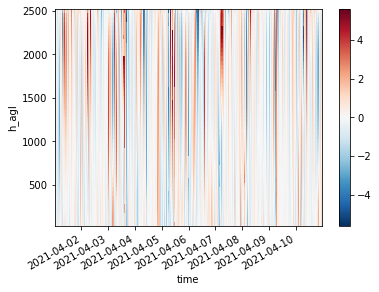